In [1]:
import os, sys

sys.path.append(os.path.dirname(os.getcwd()))

import sys
import yaml
import json
from pprint import pprint
from glob import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import pyrender
import random

import pygarment as pyg
import open3d as o3d
import trimesh
import plotly.graph_objects as go
from PIL import Image
from tqdm import tqdm
from PIL import Image
import PIL
from matplotlib.patches import FancyArrowPatch


from analysis_utils import visualize_meshes_plotly, v_id_map, plot_panel_info



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [73]:

MIN_CONSEC_VERT_TO_BE_SEGMENT = 3
# Connect Disconnected vertices, if length of disconnected vertices <= MIN_CONSEC_VERT_TO_DISCONNECT
MIN_CONSEC_VERT_TO_DISCONNECT = 2
    
    
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "back", "right", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}


PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(PROJECT_ROOT_PATH, "neutral_body/mean_all.obj")
    
default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)


BODY_TYPE = "default_body"


In [74]:
NUM = 24
STT = NUM
END = NUM + 6
JOIN_PATH_LIST = [
    f"garments_5000_{i}" for i in range(STT, END)
]

garment_path_list = []
for join_path in JOIN_PATH_LIST:
    garment_path_list.extend(
        sorted(list(filter(
            os.path.isdir,
            glob(os.path.join(GARMENT_ROOT_PATH, join_path, BODY_TYPE, "*"))
        )))
    )
    

In [75]:
from time import time

making filtered2full_idx_map 0.006727457046508789
making filtered_vertices 1.9382362365722656
making filtered_edges 0.2939443588256836
making filtered_faces 0.05388164520263672
making filtered_mesh 0.00010848045349121094
making filtered_stitch_vertex_mask_dict 0.12763428688049316
making fltrd_vis_vert_mask_dict 7.937608480453491
making vis_sim_segment_pos_dict 0.16632866859436035
stitch idx 19
[355]
stitch idx 23
[]
making fltrd_seam_line_dict 23.0711612701416
making fltrd_vis_seam_line_dict 0.0285794734954834


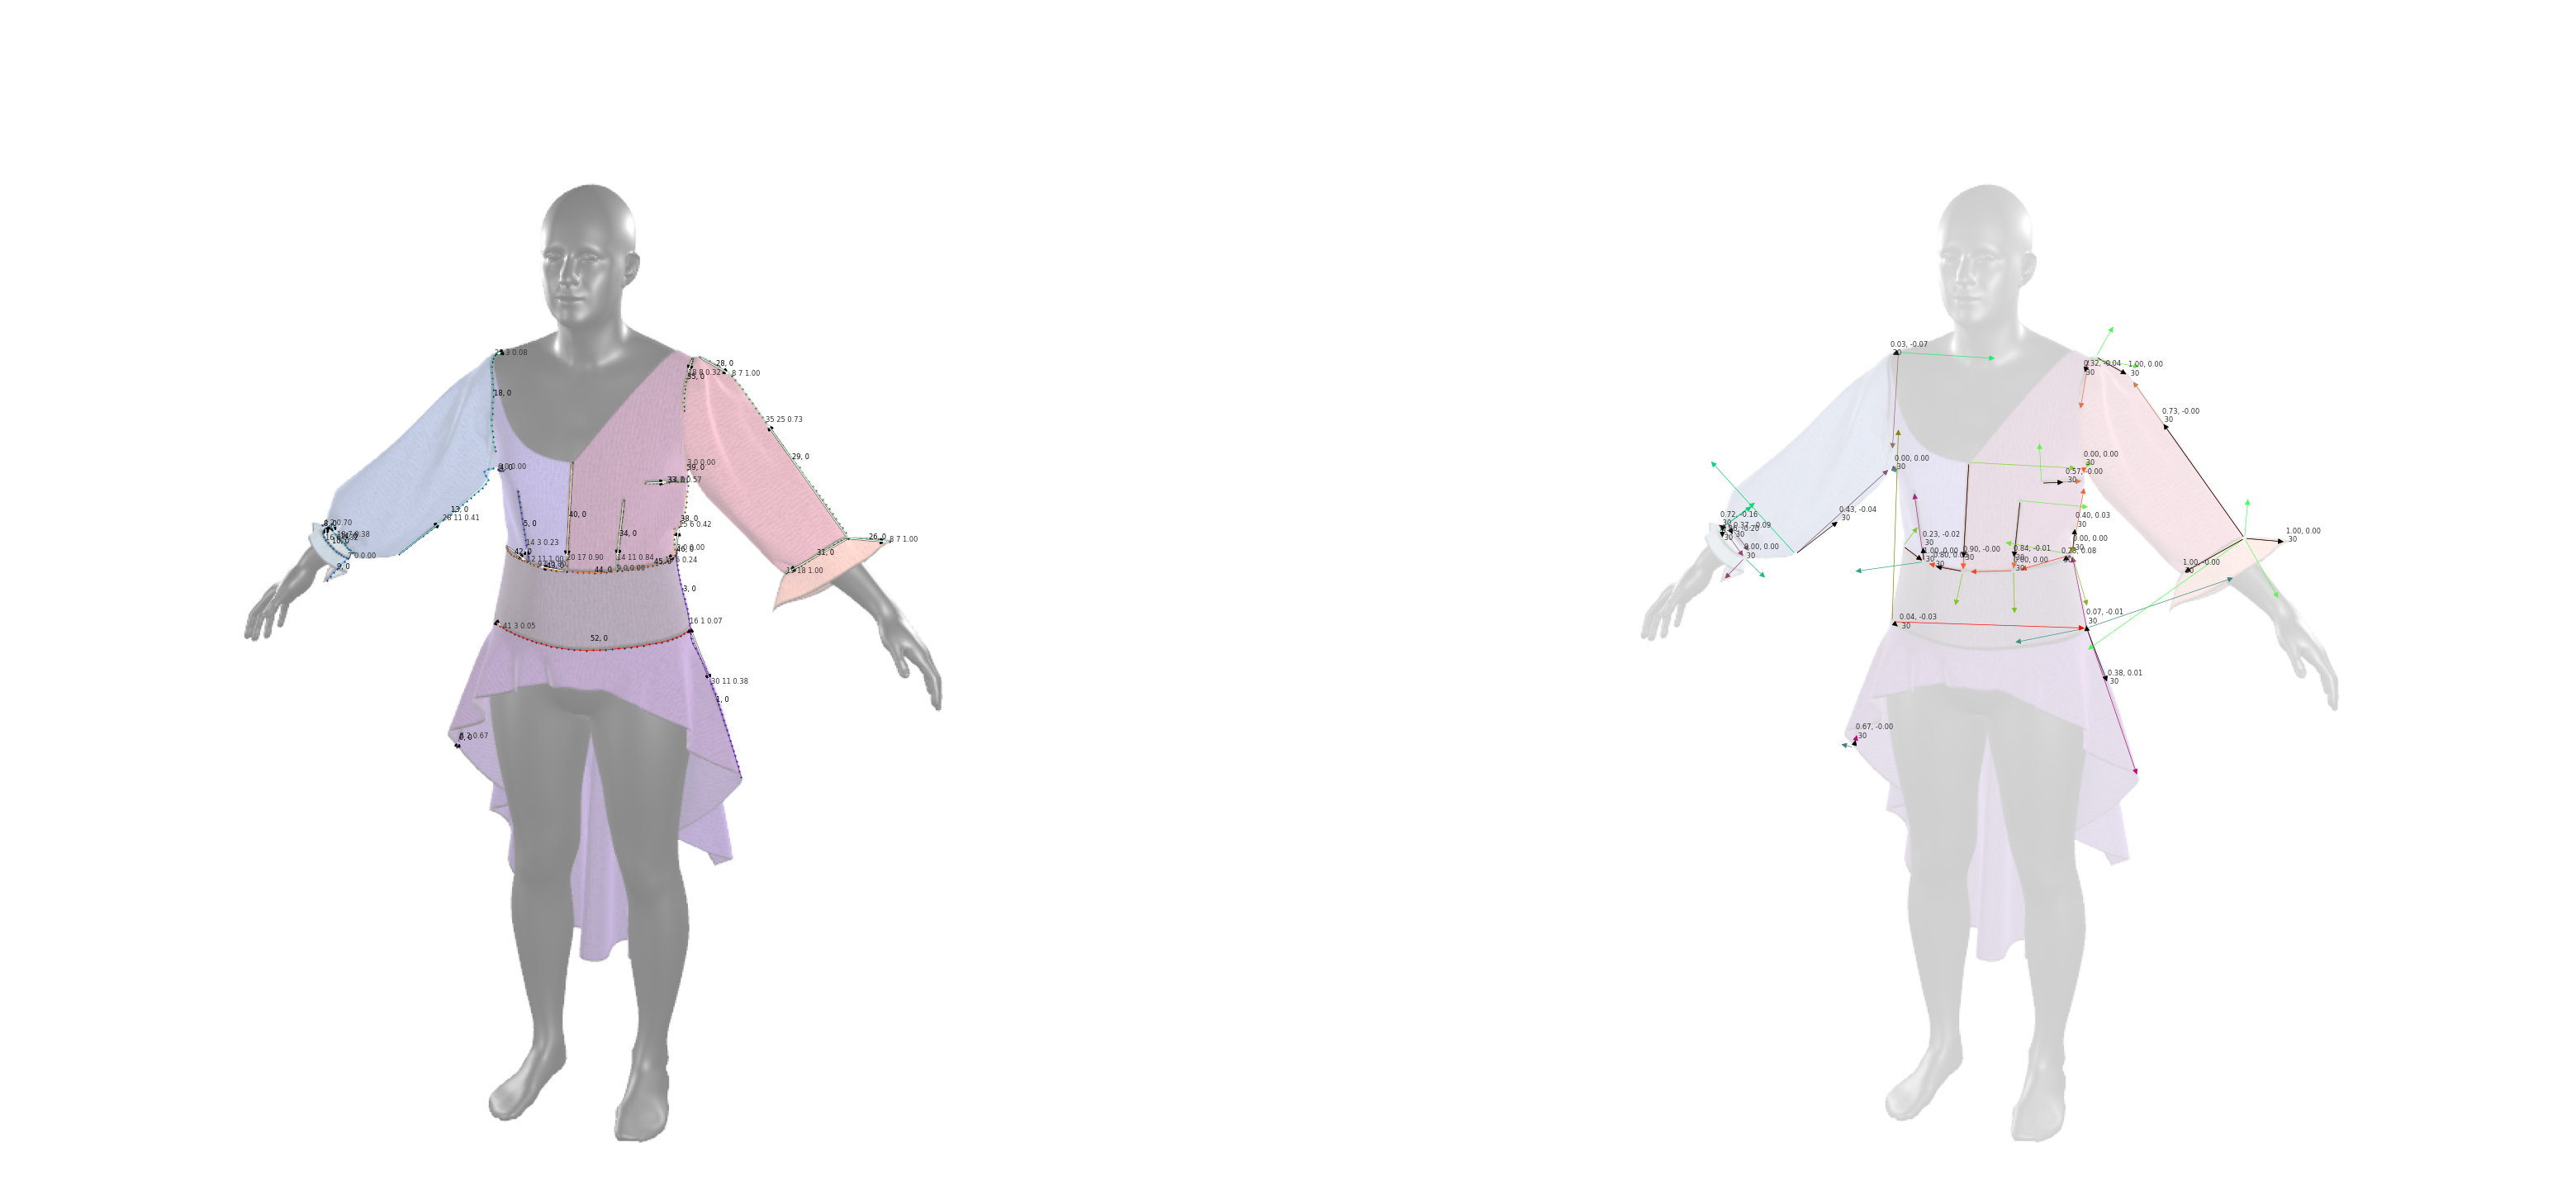

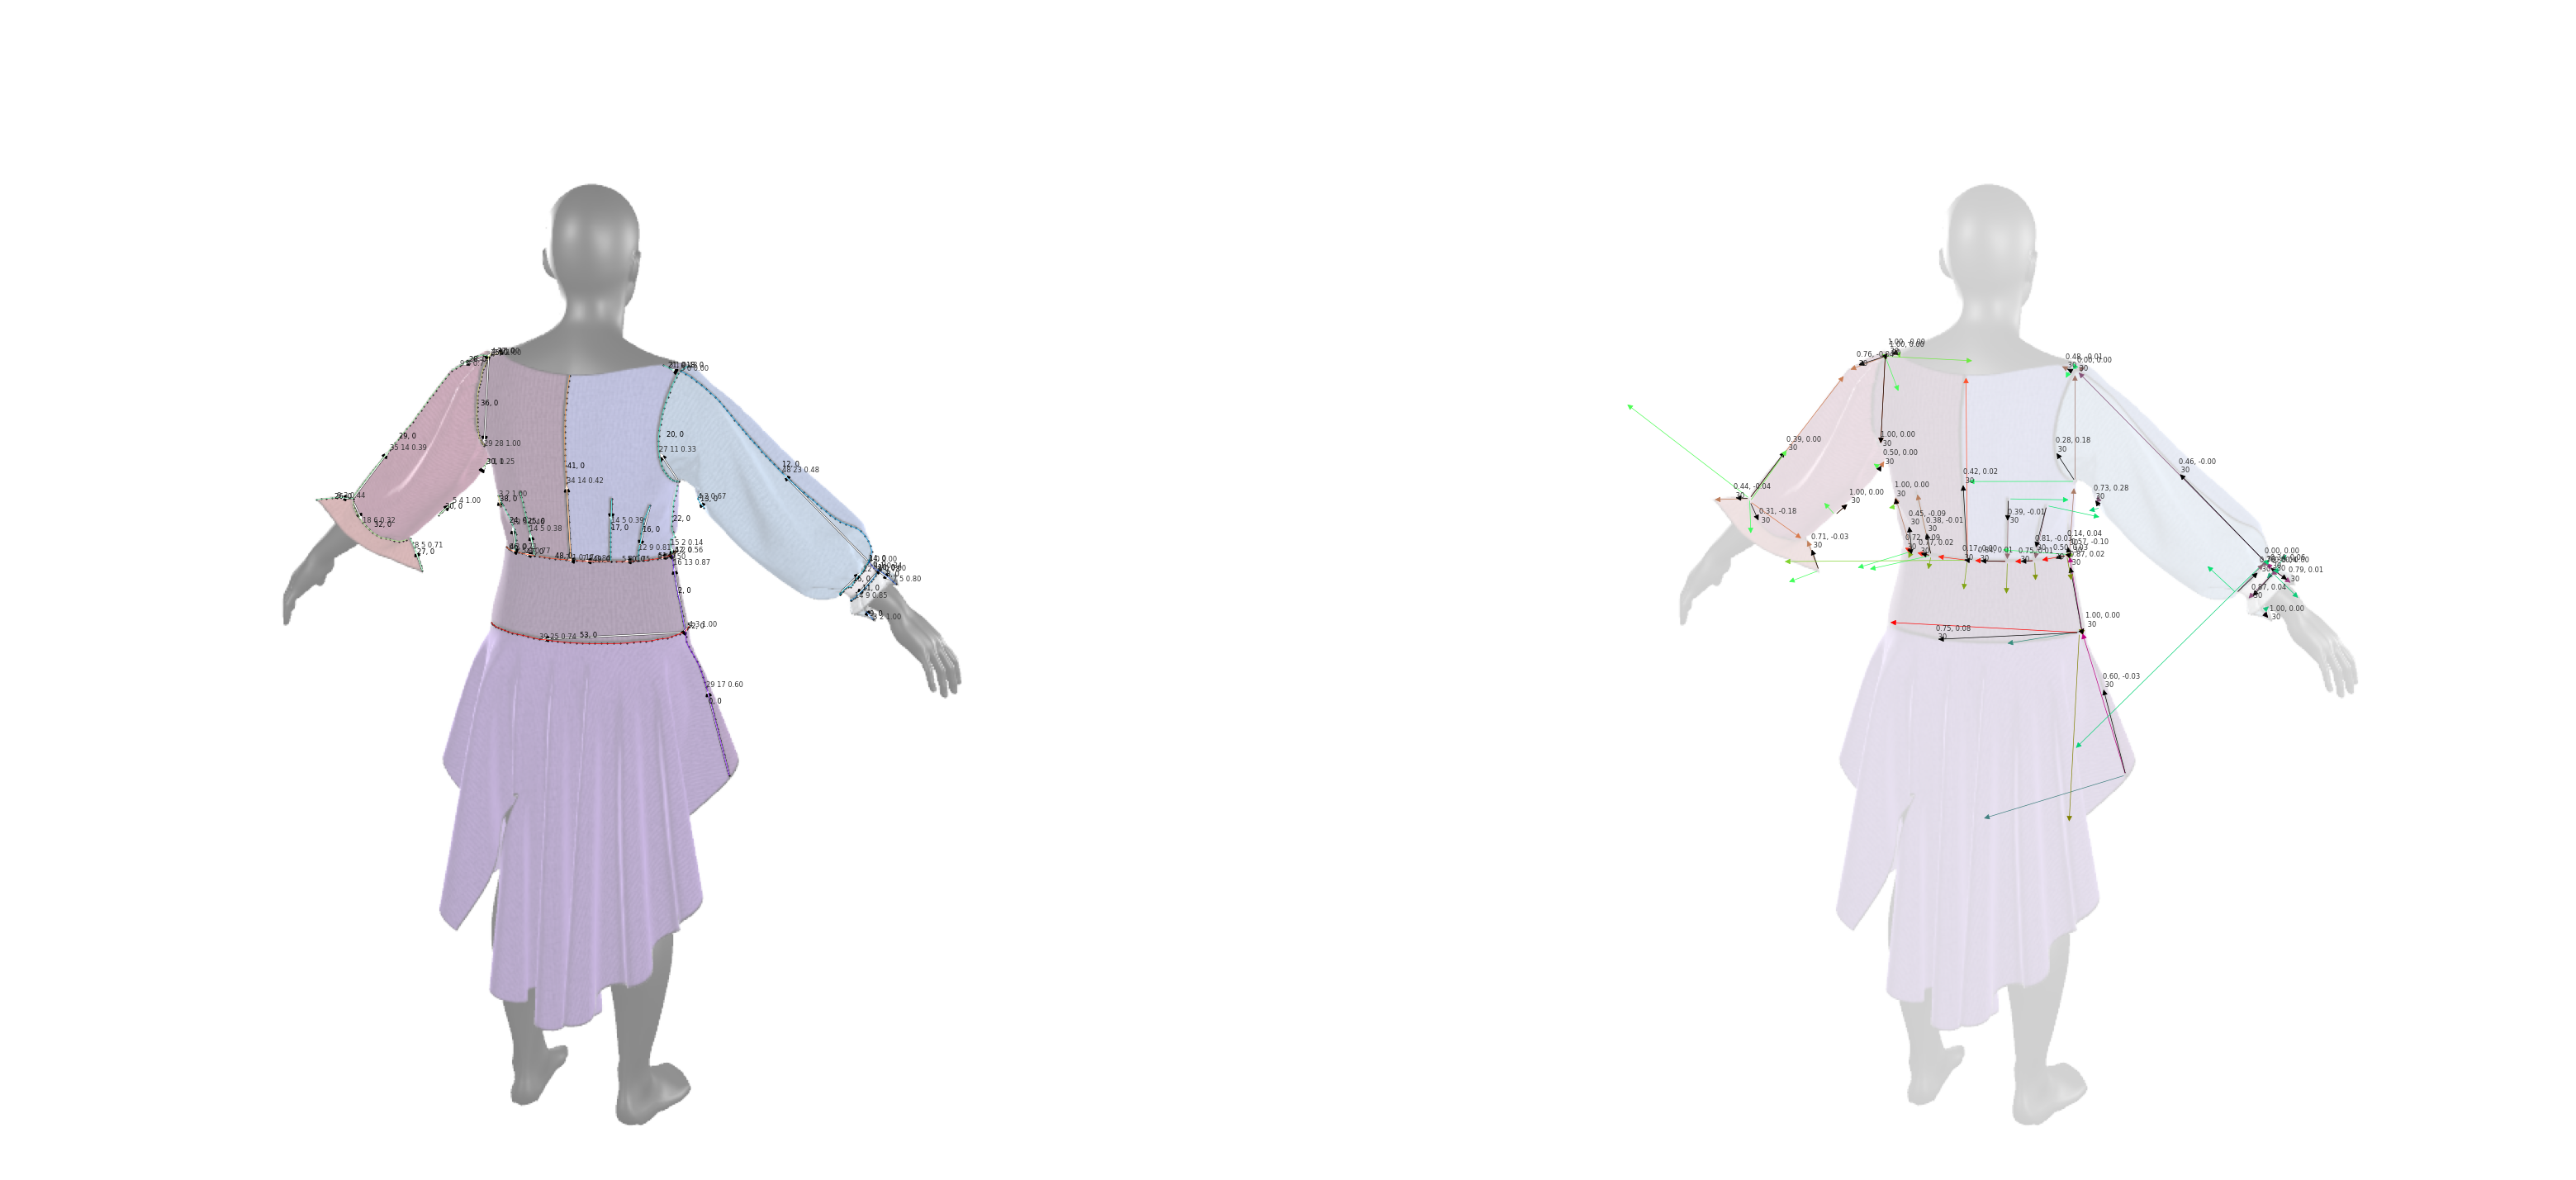

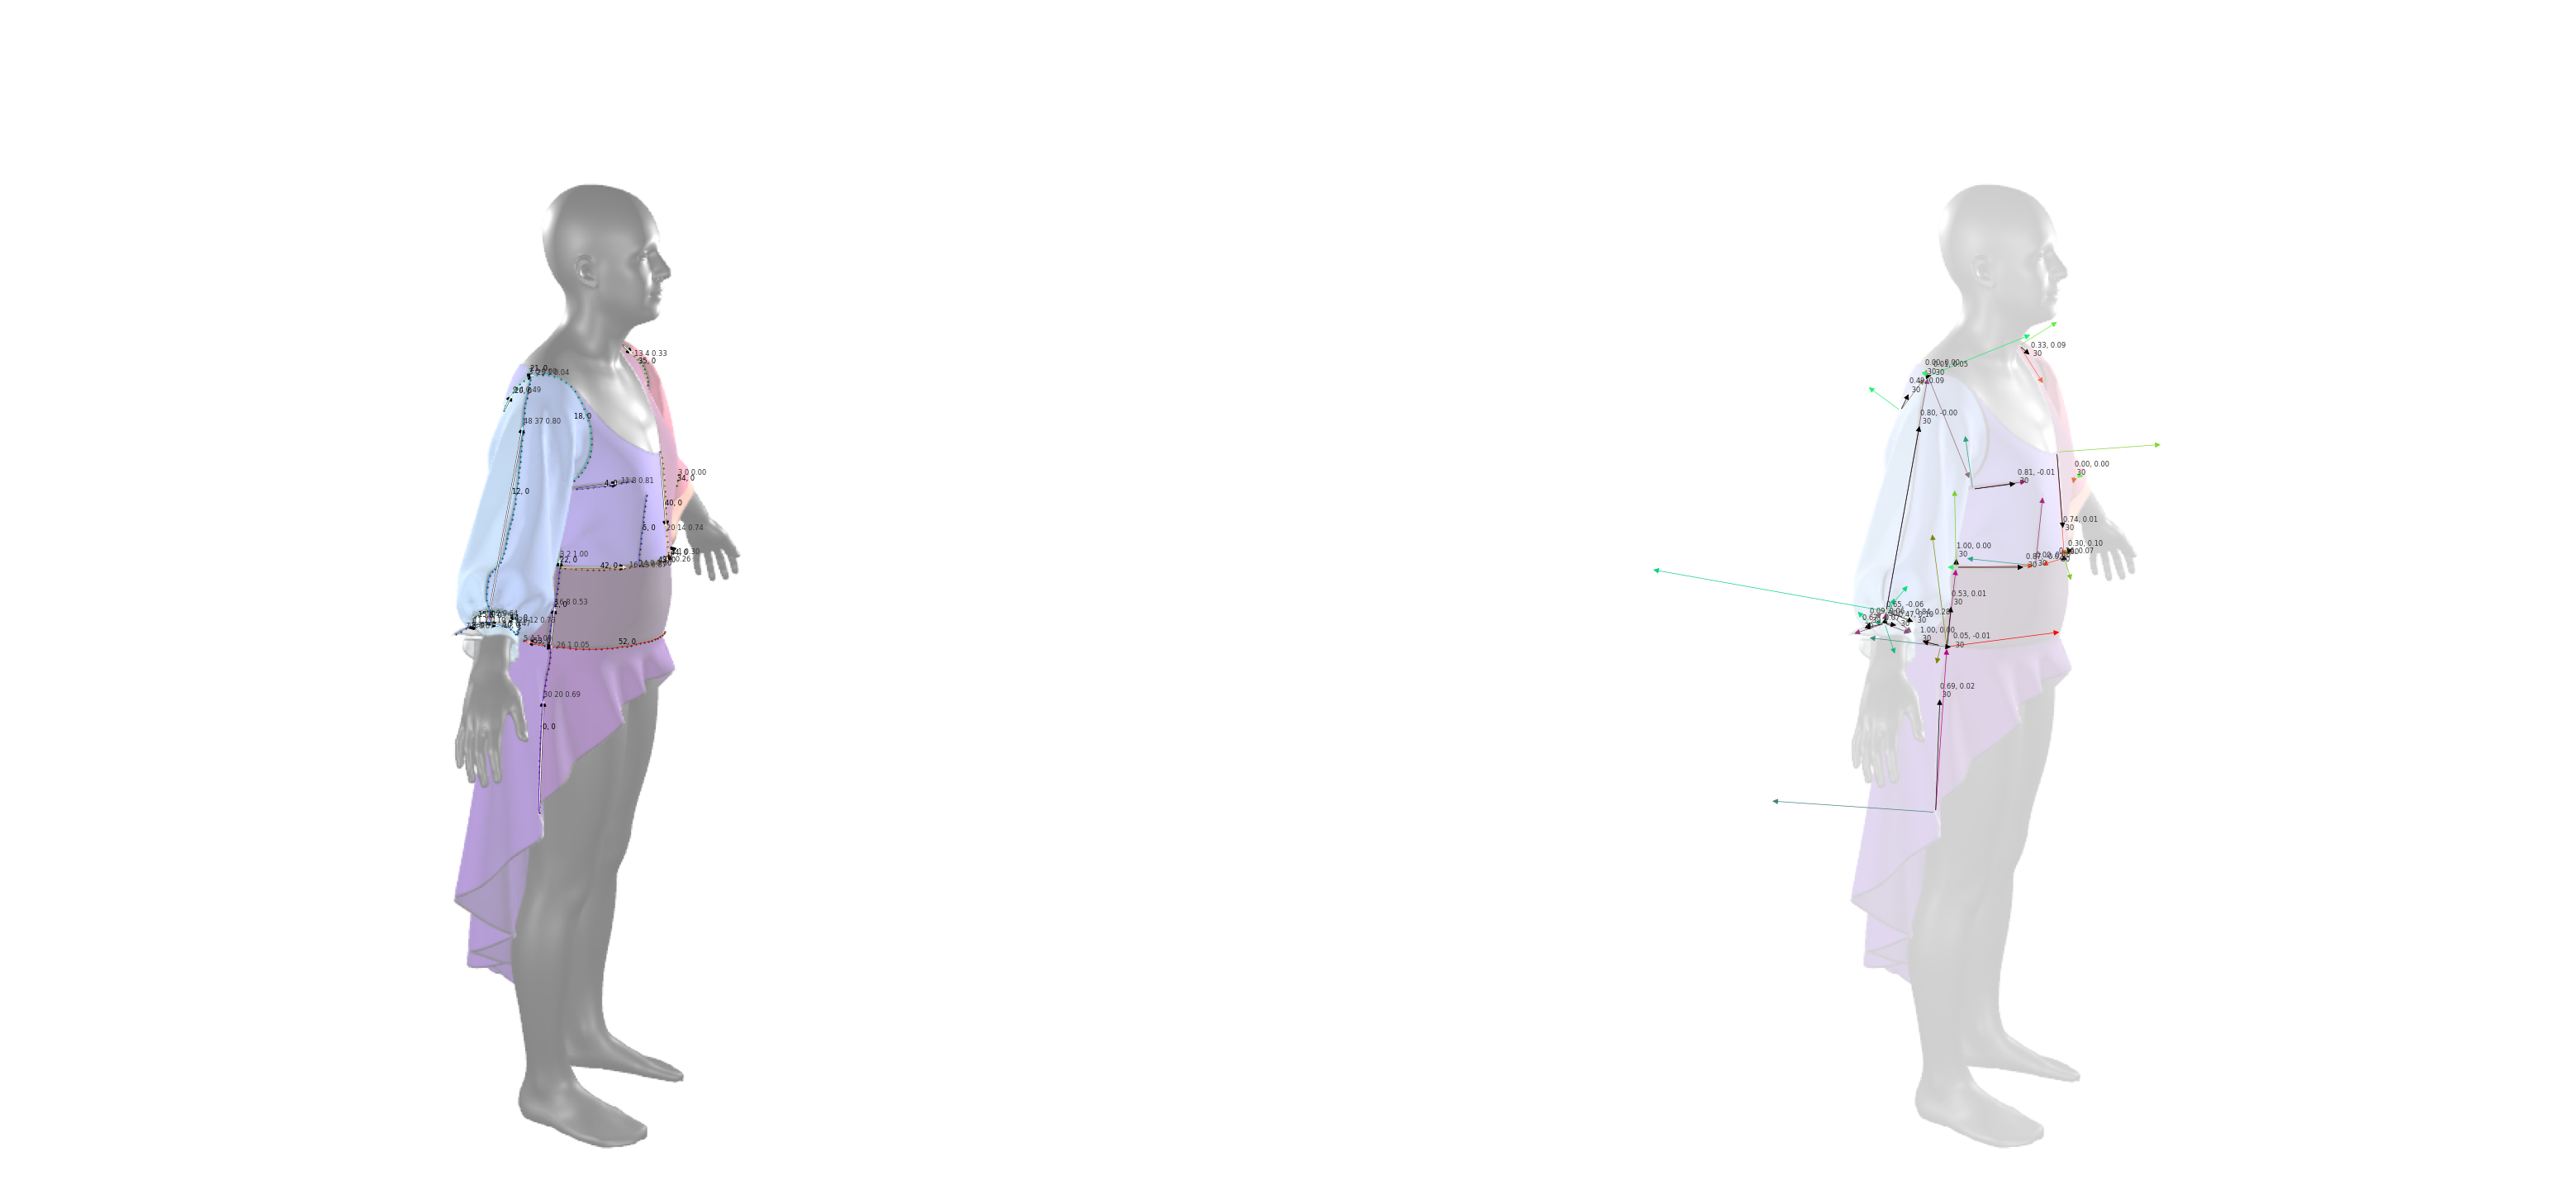

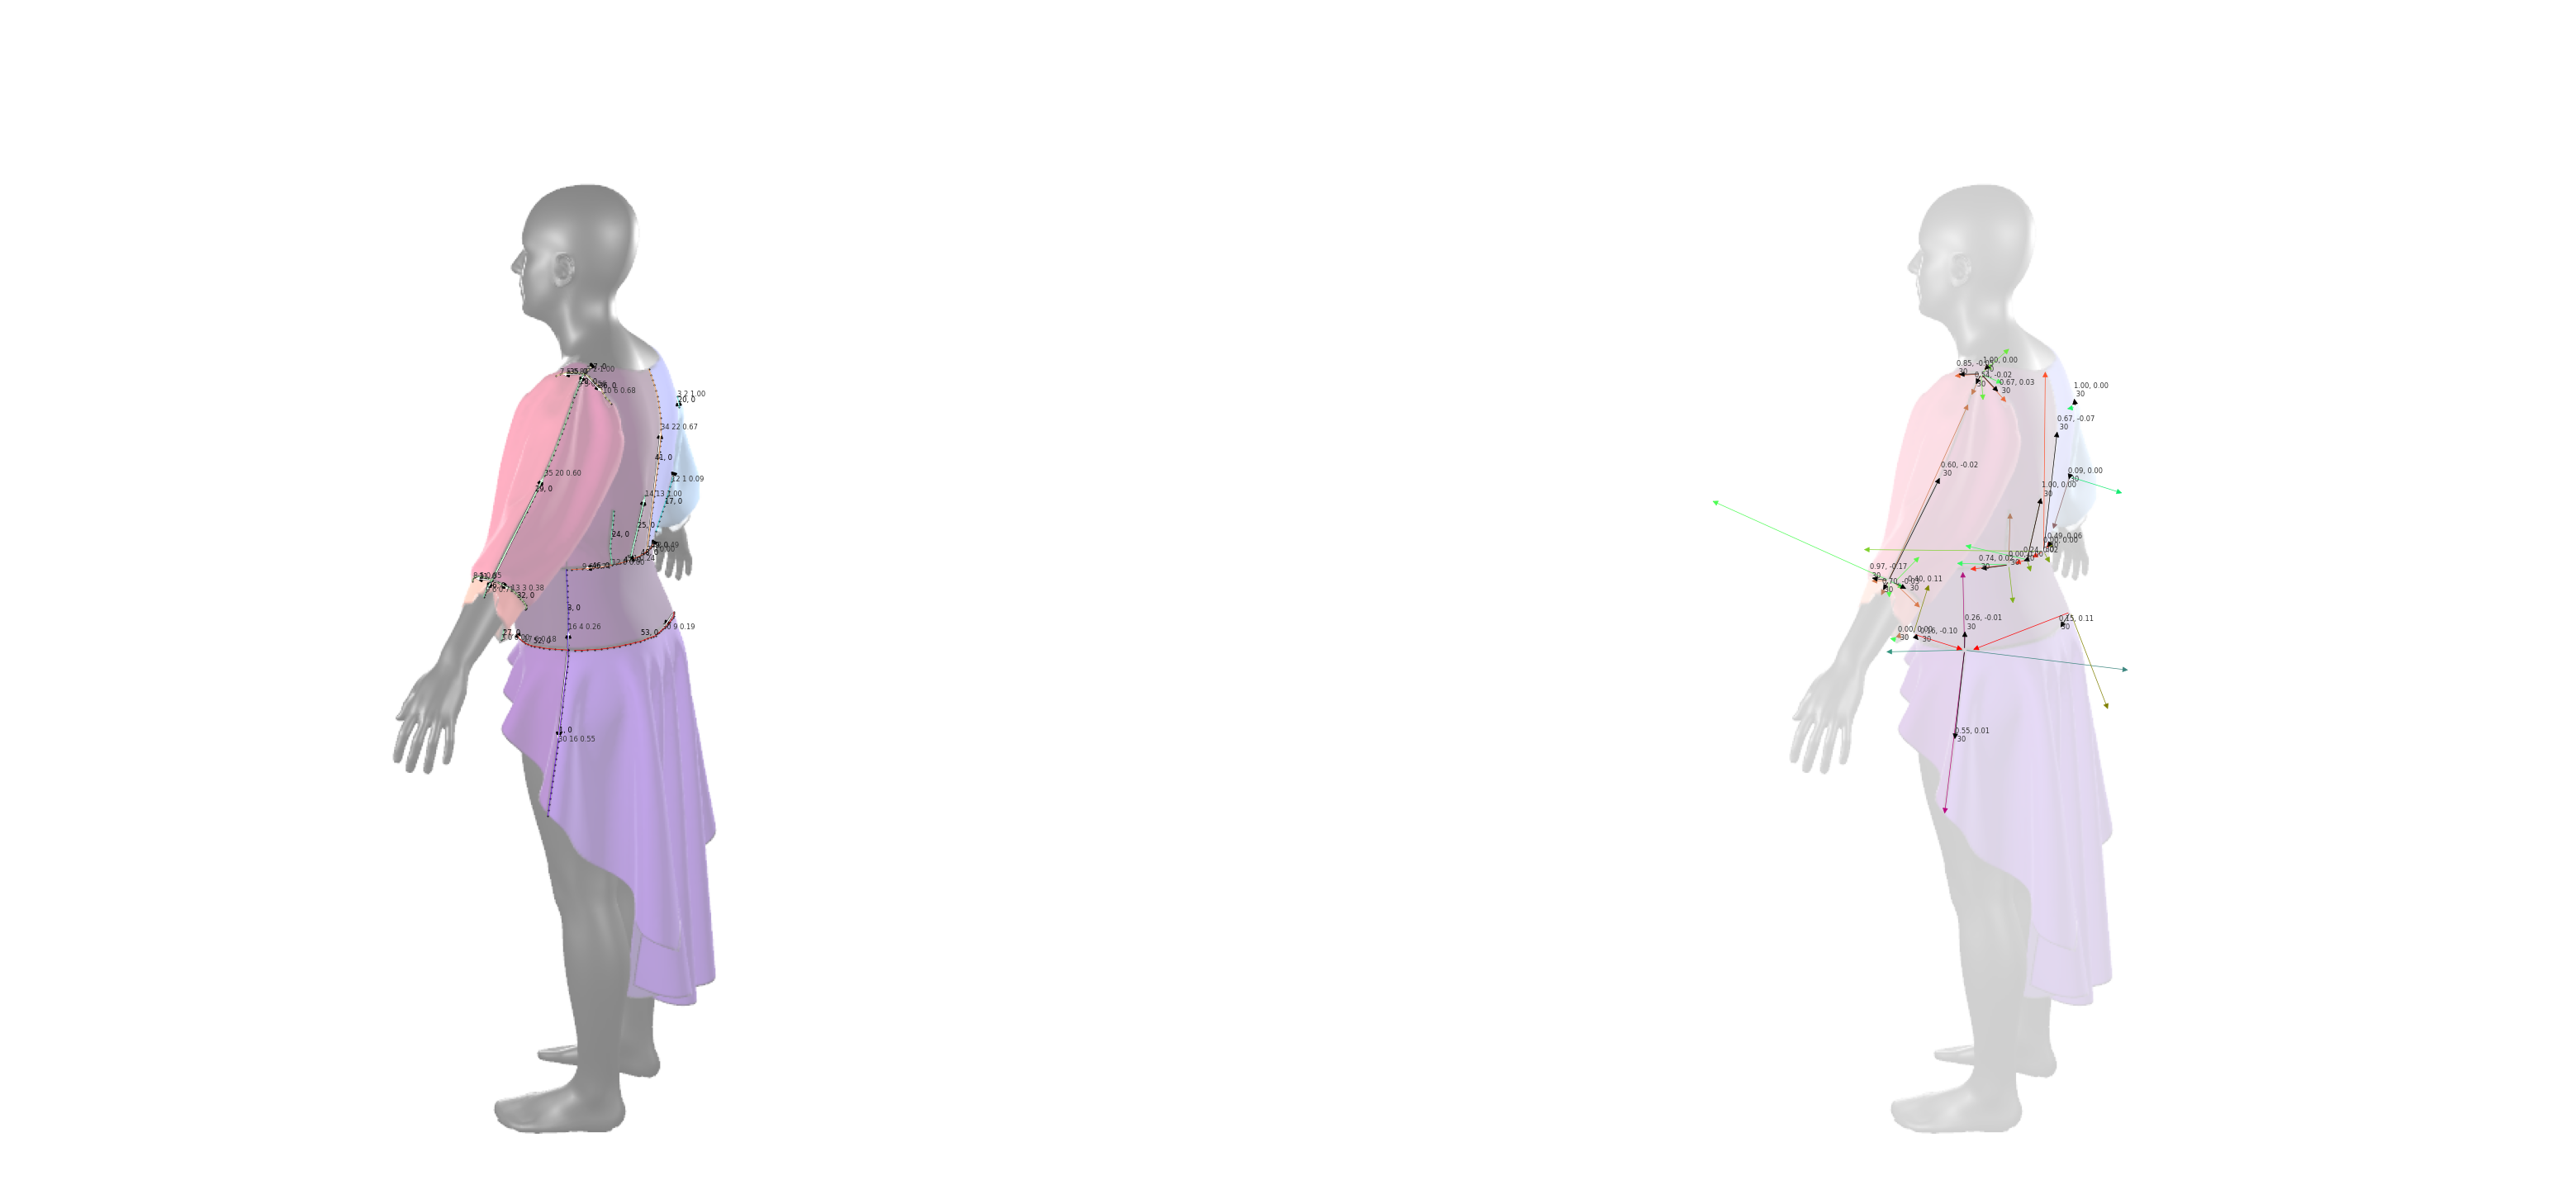

In [255]:
VIS = True
NCOLS = 2
FIGLEN = 20

IDX = 500
IDX = 1000
IDX = 2000
IDX = 3000
IDX = 4000

IDX = random.randint(0, len(garment_path_list) - 1)


garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)
SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)
panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

with open(os.path.join(garment_path, f"{garment_id}_sim_segmentation.txt"), "r") as f:
    segmentation = list(map(
        lambda x : x.strip(),
        f.readlines()
    ))

with open(os.path.join(garment_path, f"{garment_id}_projected_vertex_pose.json"), "r") as f:
    projected_vertex_pose_dict = json.load(f)

with open(os.path.join(garment_path, f"{garment_id}_vertex_visibility_mask.json"), "r") as f:
    vertex_visibility_mask_dict = json.load(f)

simulated_garment_mesh = trimesh.load_mesh(
    os.path.join(garment_path, f"{garment_id}_sim.ply"),
    process=False
)
simulated_garment_mesh.vertices = simulated_garment_mesh.vertices / 100

idx_convert_map = np.array(v_id_map(simulated_garment_mesh.vertices))

stitch_vertex_mask_dict = {}
for k in stitch_dict.keys():
    raw_mask = list(map(
        lambda x : True if f"stitch_{k}" in x.split(",") else False,
        segmentation
    ))
    base_mask = np.array(list(map(
        lambda idx : True if raw_mask[idx] else False,
        idx_convert_map
    )))
    stitch_vertex_mask_dict[k] = base_mask
    

full_vertices = np.array(simulated_garment_mesh.vertices)
full_edges = np.array(simulated_garment_mesh.edges)
full_faces = np.array(simulated_garment_mesh.faces)


stt1 = time()

filtered2full_idx_map = {}
for idx, filtered_idx in enumerate(idx_convert_map):
    if filtered_idx in filtered2full_idx_map :
        filtered2full_idx_map[filtered_idx].append(idx)
    else:
        filtered2full_idx_map[filtered_idx] = [idx]

print("making filtered2full_idx_map", time() - stt1)
stt2 = time()

        
filtered_idx_list = []
filtered_vertices = []
for full_idx, filtered_idx in enumerate(idx_convert_map):
    if filtered_idx in filtered_idx_list:
        continue
    filtered_idx_list.append(filtered_idx)
    filtered_vertices.append(full_vertices[full_idx])
filtered_vertices = np.array(filtered_vertices)

print("making filtered_vertices", time() - stt2)
stt3 = time()

filtered_edges = []
for orig_edge in full_edges:
    stt = idx_convert_map[orig_edge[0]]
    end = idx_convert_map[orig_edge[1]]
    filtered_edges.append([stt, end])
filtered_edges = np.array(filtered_edges)

print("making filtered_edges", time() - stt3)
stt4 = time()

filtered_faces = []
for idx, orig_face in enumerate(full_faces):
    
    v1, v2, v3 = sorted([
        idx_convert_map[orig_face[0]],
        idx_convert_map[orig_face[1]],
        idx_convert_map[orig_face[2]]
    ])
    filtered_faces.append([v1, v2, v3])
filtered_faces = np.array(filtered_faces)


print("making filtered_faces", time() - stt4)
stt5 = time()

filtered_mesh = trimesh.Trimesh(
    vertices=filtered_vertices,
    edges=filtered_edges,
    faces=filtered_faces,
    process=False
)

print("making filtered_mesh", time() - stt5)
stt6 = time()


filtered_stitch_vertex_mask_dict = {}
for stitch_idx in stitch_vertex_mask_dict.keys():
    filtered_stitch_vertex_mask_dict[stitch_idx] = np.array(
        [False] * len(filtered_vertices)
    )
    for orig_vert_idx, val in enumerate(stitch_vertex_mask_dict[stitch_idx]):
        if val:
            filtered_vert_idx = idx_convert_map[orig_vert_idx]
            filtered_stitch_vertex_mask_dict[stitch_idx][filtered_vert_idx] = True

print("making filtered_stitch_vertex_mask_dict", time() - stt6)
stt7 = time()

fltrd_vis_vert_mask_dict = {}
fltrd_proj_vert_pos_dict = {}

idx_convert_map_arr = np.array(idx_convert_map)
for side in vertex_visibility_mask_dict.keys():
    
    filtrd_idx_list = []
    
    fltrd_vis_mask = []
    fltrd_proj_vert_pos = []
    
    for orig_idx, fltrd_idx in enumerate(idx_convert_map_arr):
        if fltrd_idx in filtrd_idx_list:
            continue
        filtrd_idx_list.append(fltrd_idx)
        fltrd_vis_mask.append(vertex_visibility_mask_dict[side][orig_idx])
        fltrd_proj_vert_pos.append(projected_vertex_pose_dict[side][orig_idx])

    fltrd_vis_vert_mask_dict[side] = fltrd_vis_mask
    fltrd_proj_vert_pos_dict[side] = fltrd_proj_vert_pos
    
print("making fltrd_vis_vert_mask_dict", time() - stt7)
stt8 = time()
    
    
vis_sim_segment_pos_dict = {}
for side in fltrd_vis_vert_mask_dict.keys():
    for stch_idx in filtered_stitch_vertex_mask_dict.keys():
        fltrd_stch_mask = filtered_stitch_vertex_mask_dict[stch_idx]
        fltrd_vis_mask = fltrd_vis_vert_mask_dict[side]
        
        mask = fltrd_stch_mask & fltrd_vis_mask
        
print("making vis_sim_segment_pos_dict", time() - stt8)
stt9 = time()
            
# Find vertices that belong to seam line is easier done in filtered mesh
# first get idx of stitch vertices, and reorder them to construct a connected path


fltrd_seam_line_dict = {}
for fltrd_stch_idx in filtered_stitch_vertex_mask_dict.keys():
    fltrd_stch_vert_map = filtered_stitch_vertex_mask_dict[fltrd_stch_idx]
    fltrd_stch_vert_idx_arr = np.where(fltrd_stch_vert_map)[0]
    
    adj_dict = {}
    for v1, v2 in filtered_edges:
        if v1 in fltrd_stch_vert_idx_arr and v2 in fltrd_stch_vert_idx_arr:
            if v1 not in adj_dict: adj_dict[v1] = set()
            if v2 not in adj_dict: adj_dict[v2] = set()
            adj_dict[v1].add(v2)
            adj_dict[v2].add(v1)
    
    endpoints = [
        v for v in fltrd_stch_vert_idx_arr if len(adj_dict.get(v, set())) == 1
    ]
    if len(endpoints) != 2:
        
        print("stitch idx", fltrd_stch_idx)
        print(fltrd_stch_vert_idx_arr)
        print(f"Warning: Found {len(endpoints)} endpoints, expected 2. Path may not be linear.")
        continue
    
    seam_vert_idx_list = [endpoints[0]]
    while len(seam_vert_idx_list) < len(fltrd_stch_vert_idx_arr):
        current_vert = seam_vert_idx_list[-1]
        neighbors = adj_dict[current_vert]
        next_vert = next((v for v in neighbors if v not in seam_vert_idx_list), None)
        if next_vert is None:
            break
        seam_vert_idx_list.append(next_vert)
    fltrd_seam_line_dict[fltrd_stch_idx] = seam_vert_idx_list
    
    
print("making fltrd_seam_line_dict", time() - stt9)
stt10 = time()
        
fltrd_vis_seam_line_dict = {}
for side in fltrd_vis_vert_mask_dict.keys() :
    fltrd_vis_seam_line_dict[side] = {}
    vis_mask = np.array(fltrd_vis_vert_mask_dict[side]).astype(bool)
    for stch_idx in fltrd_seam_line_dict.keys():
        
        seam_vert_idx_list = np.array(fltrd_seam_line_dict[stch_idx])
        vis_list = []
        for seam_vert_idx in seam_vert_idx_list :
            vis_list.append(vis_mask[seam_vert_idx])
        vis_list = np.array(vis_list)

        # If length of disconnection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_DISCONNECT,
        # consider the disconnection is connected
        # (which change invisible seam vertices to visible)
        idx = 0
        while idx < len(vis_list) :
            if idx >= len(vis_list) - 2 :
                break
            while not (vis_list[idx] == True and vis_list[idx + 1] == False) :
                if idx >= len(vis_list) - 2 :
                    break
                idx += 1
            if idx >= len(vis_list) - 2 :
                break
            window_end_idx = min(idx + MIN_CONSEC_VERT_TO_DISCONNECT + 1, len(vis_list) - 1)
            for rid in range(window_end_idx, idx, -1) :
                if vis_list[rid] == True :
                    vis_list[idx:rid] = True
                    break
            idx = rid
            
            
        # If length of connection between visible seam vertices
        # is less then MIN_CONSEC_VERT_TO_BE_SEGMENT,
        # consider the connection is not a segment
        # (which change visible seam vertices to invisible)
        idx = 0
        while idx < len(vis_list) :
            if vis_list[idx] != True :
                idx += 1
                continue
            idx2 = idx + 1
            while idx2 < len(vis_list) and vis_list[idx2] == True :
                idx2 += 1
            if idx2 - idx < MIN_CONSEC_VERT_TO_BE_SEGMENT :
                vis_list[idx:idx2] = False
            idx = idx2
            
        line_segment_idx_arr_list = []
        line_segment_pos_arr_list = []
        if True in vis_list :
            idx = vis_list.tolist().index(True)
            while idx < len(vis_list) :
                line_segment_idx_list = []
                line_segment_pos_list = []
                while idx < len(vis_list) and vis_list[idx] == True :
                    line_segment_idx_list.append(
                        seam_vert_idx_list[idx]
                    )
                    line_segment_pos_list.append(
                        fltrd_proj_vert_pos_dict[side][seam_vert_idx_list[idx]]
                    )
                    idx += 1
                if len(line_segment_idx_list) > 0 :
                    line_segment_idx_arr_list.append(np.array(line_segment_idx_list))
                    line_segment_pos_arr_list.append(np.array(line_segment_pos_list))
                idx += 1
        
        if len(line_segment_pos_arr_list) > 0 :
            segment_edge_len_arr_list = []
            segment_t_arr_list = []
            segment_u_arr_list = []
            segment_v_arr_list = []
            for segment_pos_arr in line_segment_pos_arr_list :
                i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
                j_vec = np.array([i_vec[1], -i_vec[0]])
                
                i_vec_normalized = i_vec / np.linalg.norm(i_vec)
                j_vec_normalized = j_vec / np.linalg.norm(j_vec)
                
                edge_len_arr = np.concatenate((
                    [0],
                    np.linalg.norm(segment_pos_arr[1:] - segment_pos_arr[:-1], axis=1)
                ))
                segment_edge_len_arr_list.append(edge_len_arr)
                t_arr = np.cumsum(edge_len_arr) / np.sum(edge_len_arr)
                segment_t_arr_list.append(t_arr)
                
                vect_arr = segment_pos_arr - segment_pos_arr[0]
                u_arr = np.sum(vect_arr * i_vec_normalized, axis=1) / np.linalg.norm(i_vec)
                v_arr = np.sum(vect_arr * j_vec_normalized, axis=1) / np.linalg.norm(j_vec)
                
                if len(t_arr) != len(u_arr) or len(t_arr) != len(v_arr) :
                    print(side, stch_idx)
                    print(edge_len_arr.shape, t_arr.shape, u_arr.shape, v_arr.shape)
                    print("error")
                
                error_num = np.sum(
                    vect_arr - (u_arr.reshape(-1, 1) * i_vec.reshape(1, -1) + v_arr.reshape(-1, 1) * j_vec.reshape(1, -1))
                )
                if error_num > 1e-6 :
                    print(side, stch_idx)
                    print(vect_arr.shape, u_arr.shape, v_arr.shape)
                    print(error_num)
                    print("error")
                
                segment_t_arr_list.append(t_arr)
                segment_u_arr_list.append(u_arr)
                segment_v_arr_list.append(v_arr)
            
            fltrd_vis_seam_line_dict[side][stch_idx] = {
                "raw_idx_arr" : seam_vert_idx_list,
                "raw_vis_mask" : vis_list,
                "segment_idx_arr_list" : line_segment_idx_arr_list,
                "segment_pos_arr_list" : line_segment_pos_arr_list,
                "segment_edge_len_arr_list" : segment_edge_len_arr_list,
                "segment_t_arr_list" : segment_t_arr_list,
                "segment_u_arr_list" : segment_u_arr_list,
                "segment_v_arr_list" : segment_v_arr_list
            }

print("making fltrd_vis_seam_line_dict", time() - stt10)
stt11 = time()

## Save
# with open(os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl"), "wb") as f:
#     pickle.dump(fltrd_vis_seam_line_dict, f)

## Visualize


if VIS :
    rendered_image_dict = {}
    for side in fltrd_vis_seam_line_dict.keys():
        rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"{garment_id}_render_{side}.png"))
    STCH_IDX_MAX = max(list(map(
        lambda stch_dict : max(stch_dict.keys()),
        fltrd_vis_seam_line_dict.values()
    )))
    colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))
    
    for side in fltrd_vis_seam_line_dict.keys():
        plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN))
        ax1 = plt.subplot(1, NCOLS, 1)
        ax1.imshow(rendered_image_dict[side], alpha=0.5)
        ax1.axis("off")
        
        ax2 = plt.subplot(1, NCOLS, 2)
        ax2.imshow(rendered_image_dict[side], alpha=0.2)
        ax2.axis("off")
    
        for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
            for segment_idx, (
                segment_idx_arr, segment_pos_arr,
                segment_edge_len_arr, segment_t_arr,
                segment_u_arr, segment_v_arr
            ) in enumerate(zip(
                seam_dict["segment_idx_arr_list"],
                seam_dict["segment_pos_arr_list"],
                seam_dict["segment_edge_len_arr_list"],
                seam_dict["segment_t_arr_list"],
                seam_dict["segment_u_arr_list"],
                seam_dict["segment_v_arr_list"]
            )):
                
                i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
                j_vec = np.array([i_vec[1], -i_vec[0]])
                
                
                # print(
                #     len(segment_idx_arr), len(segment_pos_arr),
                #     len(edge_len_arr), len(t_arr),
                #     len(u_arr), len(v_arr)
                # )
                
                ax1.annotate(
                    f"{seam_idx}, {segment_idx}",
                    xy = (segment_pos_arr.mean(axis=0)),
                    xytext = (segment_pos_arr.mean(axis=0)),
                    fontsize=6
                )
                ax1.plot(
                    segment_pos_arr[:, 0],
                    segment_pos_arr[:, 1],
                    '-',
                    color=colors[seam_idx],
                    linewidth=0.5
                )
                ax1.scatter(
                    segment_pos_arr[:, 0],
                    segment_pos_arr[:, 1],
                    color="black",
                    s=0.2
                )
                
                
                arrow_i = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[0] + i_vec,
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color=np.mean(
                        [colors[seam_idx], np.array([1, 0, 0, 1])],
                        axis=0
                    ),
                    linewidth=0.5
                )
                
                arrow_j = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[0] + j_vec,
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color=np.mean(
                        [colors[seam_idx], np.array([0, 1, 0, 1])],
                        axis=0
                    ),
                    linewidth=0.5
                )
                ax2.add_patch(arrow_i)
                ax2.add_patch(arrow_j)
                
                random_idx = random.randint(0, len(segment_pos_arr) - 1)
                t = segment_t_arr[random_idx]
                u = segment_u_arr[random_idx]
                v = segment_v_arr[random_idx]
                
                ax1.annotate(
                    f"{len(segment_pos_arr)} {random_idx} {t:.2f}",
                    xy = (segment_pos_arr[random_idx]),
                    xytext = (segment_pos_arr[random_idx]),
                    fontsize=6, color=(0.2, 0.2, 0.2, 1)
                )
                
                arrow_1 = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[random_idx],
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color='black',
                    linewidth=1.5
                )
                arrow_2 = FancyArrowPatch(
                    segment_pos_arr[0],
                    segment_pos_arr[0] + u * i_vec + v * j_vec,
                    arrowstyle='-|>',
                    mutation_scale=5,
                    color='white',
                    linewidth=1
                )
                ax1.add_patch(arrow_1)
                ax1.add_patch(arrow_2)
                
                
                ax2.annotate(
                    f"{u:.2f}, {v:.2f} \n {len(vect_arr)}",
                    xy = (segment_pos_arr[random_idx]),
                    xytext = (segment_pos_arr[random_idx]),
                    fontsize=6, color=(0.2, 0.2, 0.2, 1)
                )
                
                arrow_2 = FancyArrowPatch(
                    segment_pos_arr[0],
                    segment_pos_arr[0] + u * i_vec + v * j_vec,
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color='black',
                    linewidth=0.5
                )
                ax2.add_patch(arrow_2)
                

    if VIS :
        plt.show()

In [252]:
IDX

# 16265

16265

In [250]:
for side, scene_dict in fltrd_vis_seam_line_dict.items():
    for scene_idx, scene_dict in scene_dict.items():
        for segment_idx, (segment_idx_arr, segment_pos_arr, segment_edge_len_arr, segment_t_arr, segment_u_arr, segment_v_arr) in enumerate(zip(
            scene_dict["segment_idx_arr_list"],
            scene_dict["segment_pos_arr_list"],
            scene_dict["segment_edge_len_arr_list"],
            scene_dict["segment_t_arr_list"],
            scene_dict["segment_u_arr_list"],
            scene_dict["segment_v_arr_list"]
        )):
            
            if (
                len(segment_idx_arr) != len(segment_pos_arr)
            ) or (
                len(segment_edge_len_arr) != len(segment_t_arr)
            ) or (
                len(segment_u_arr) != len(segment_v_arr)
            ):
                print(side, scene_idx)
                
                print(
                    len(segment_idx_arr), len(segment_pos_arr),
                    len(segment_edge_len_arr), len(segment_t_arr),
                    len(segment_u_arr), len(segment_v_arr)
                )
                
                print("error")
            

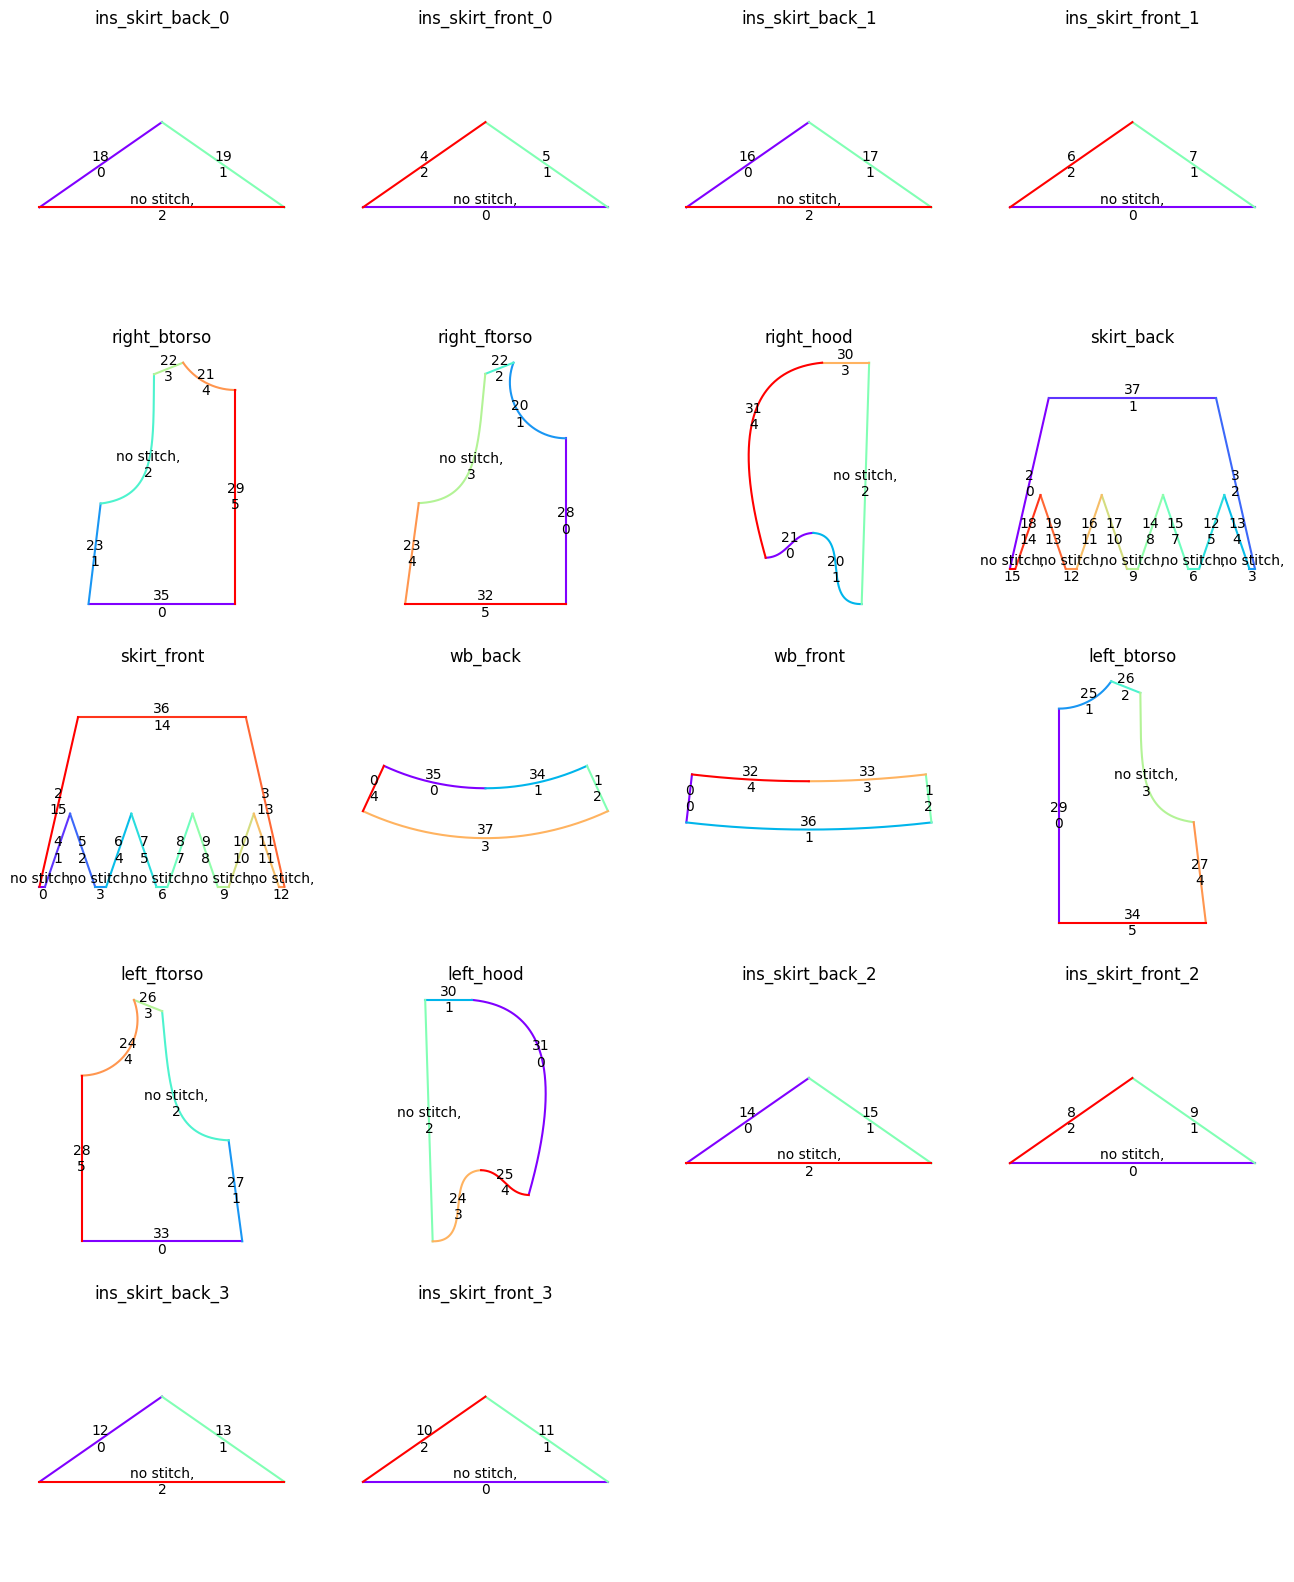

In [117]:
FIGLEN = 4
NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))
NCOLS = 4
NROWS = 5

plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    ax.set_title(panel_name)
    ax.axis("off")
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
# plt.savefig(f"{garment_id}_panel_vis.png")
plt.show()

[390.50409242 571.86867978]
[390.50409242 571.86867978]

[397.05769651 516.1467432 ]
[397.05769651 516.1467432 ]

[351.45654217 541.99703853]
[351.45654217 541.99703853]

[396.1110198 528.0769706]
[396.1110198 528.0769706]

[460.47406796 562.62606519]
[460.47406796 562.62606519]

[470.22938057 500.64319371]
[470.22938057 500.64319371]

[466.89487216 427.53164726]
[466.89487216 427.53164726]

[457.76292822 545.09048586]
[457.76292822 545.09048586]

[384.04893431 450.36703106]
[384.04893431 450.36703106]

[389.93880932 487.07437885]
[389.93880932 487.07437885]



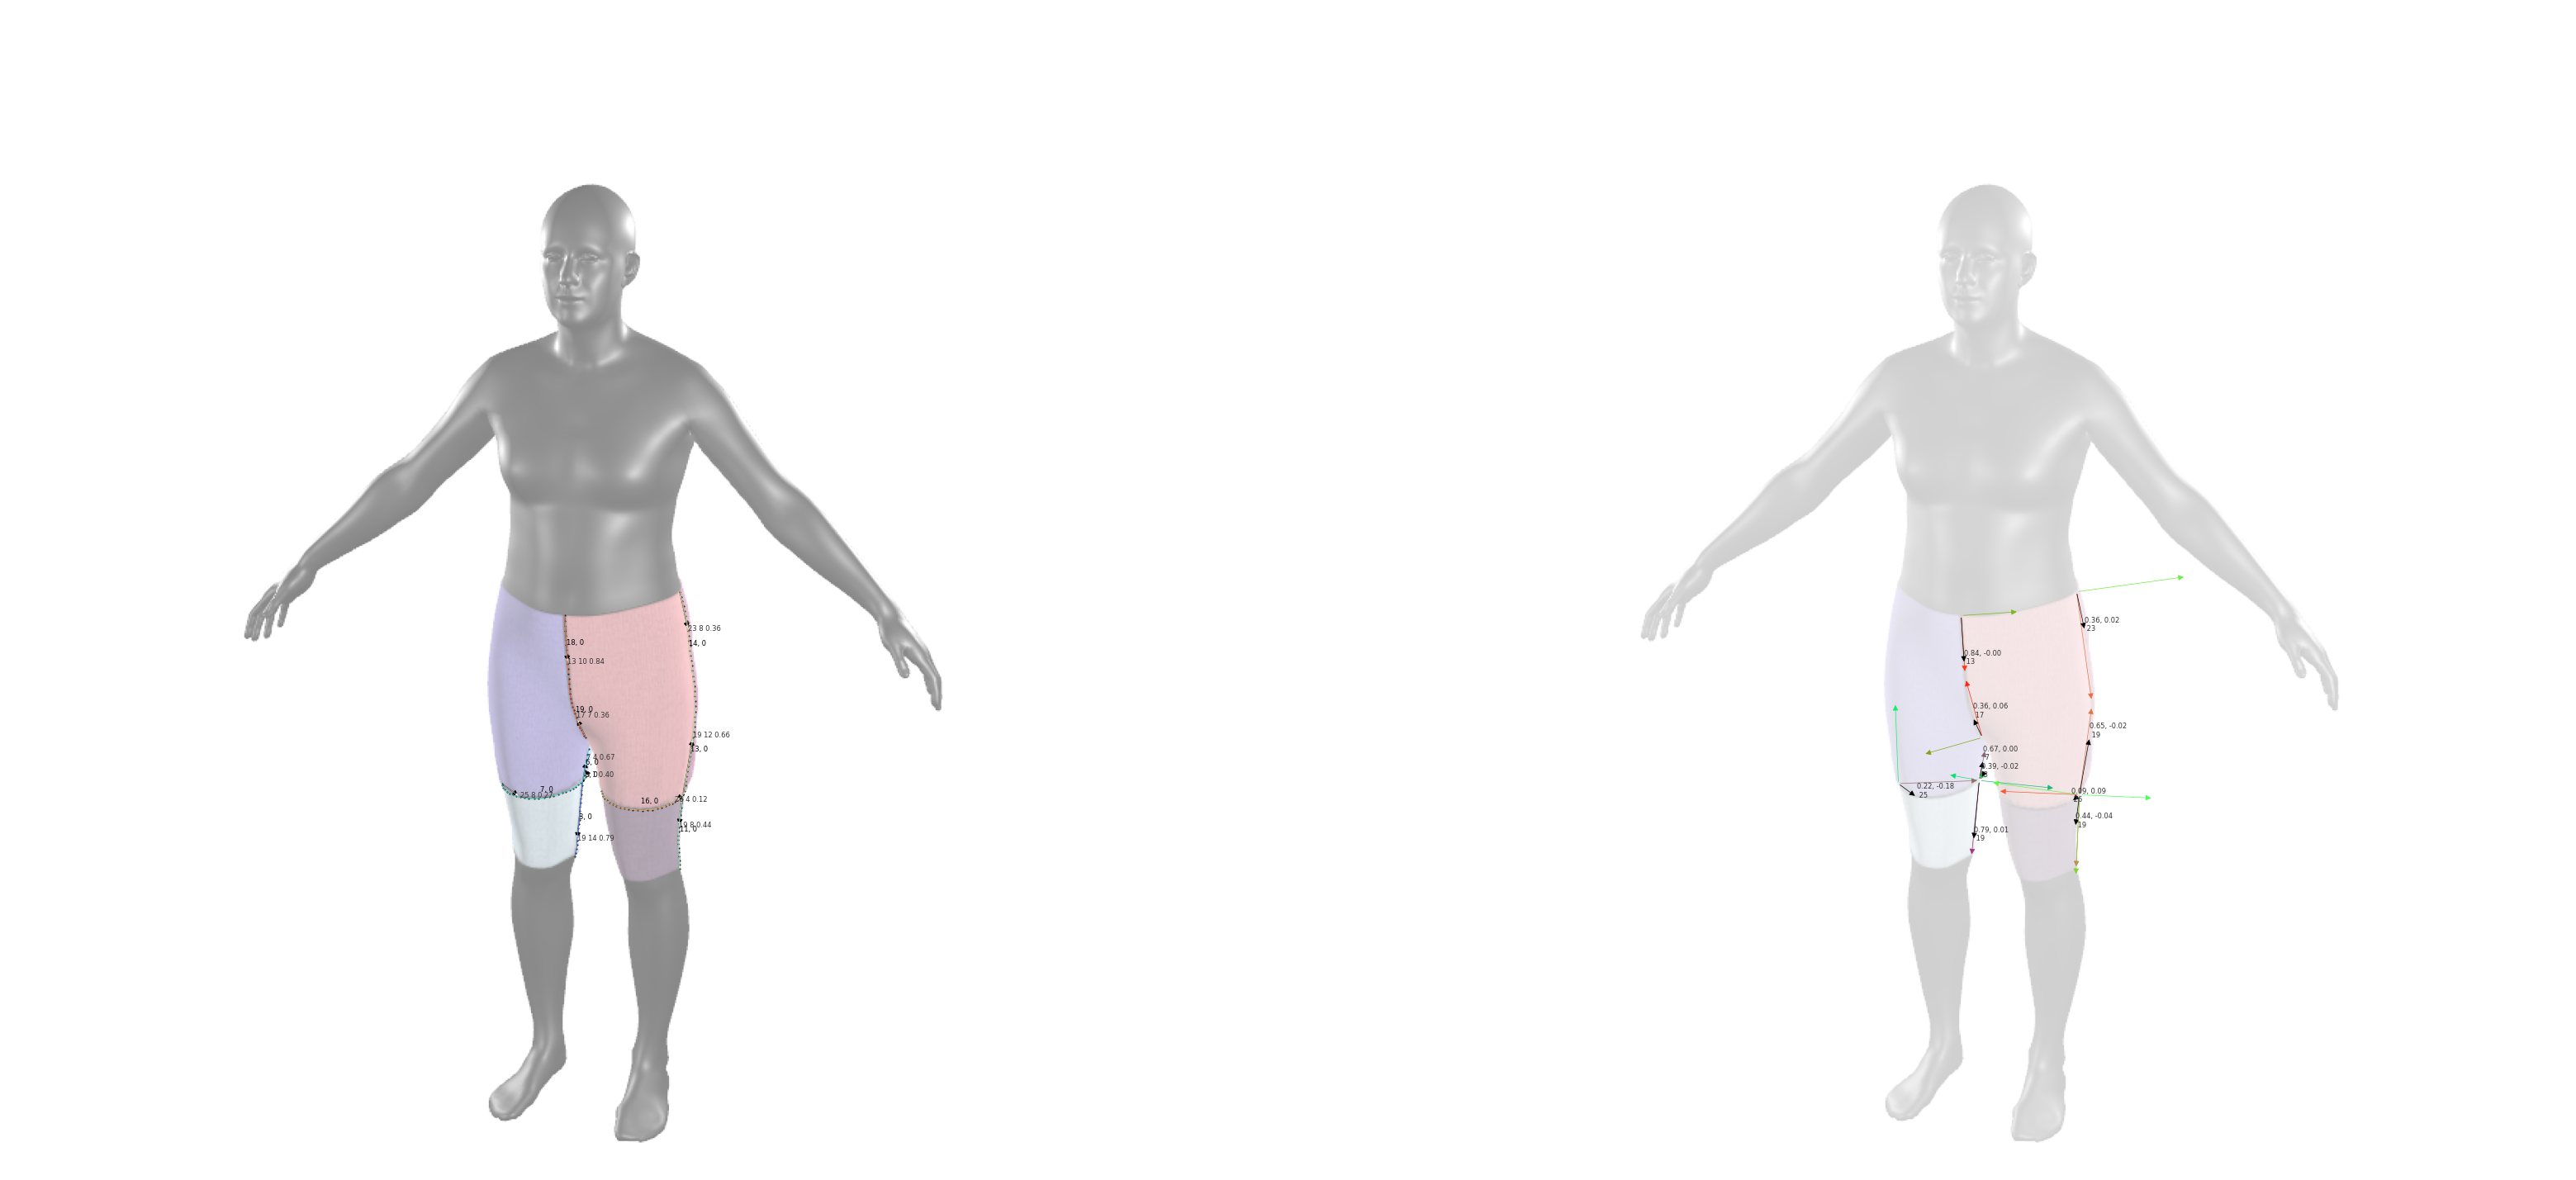

[438.52948012 463.94990613]
[438.52948012 463.94990613]

[411.65171408 457.92686705]
[411.65171408 457.92686705]

[458.27608105 555.25816614]
[458.27608105 555.25816614]

[470.99924239 487.28492547]
[470.99924239 487.28492547]

[467.06280612 438.86920058]
[467.06280612 438.86920058]

[433.41844324 548.9281736 ]
[433.41844324 548.9281736 ]

[335.00362231 442.50505921]
[335.00362231 442.50505921]

[351.24586211 462.82603318]
[351.24586211 462.82603318]

[387.39387294 561.0352331 ]
[387.39387294 561.0352331 ]

[393.35743287 524.85828584]
[393.35743287 524.85828584]

[391.70949395 532.06426043]
[391.70949395 532.06426043]

[377.31266094 538.50598199]
[377.31266094 538.50598199]

[385.03966282 414.17533254]
[385.03966282 414.17533254]

[389.90339706 491.86221915]
[389.90339706 491.86221915]



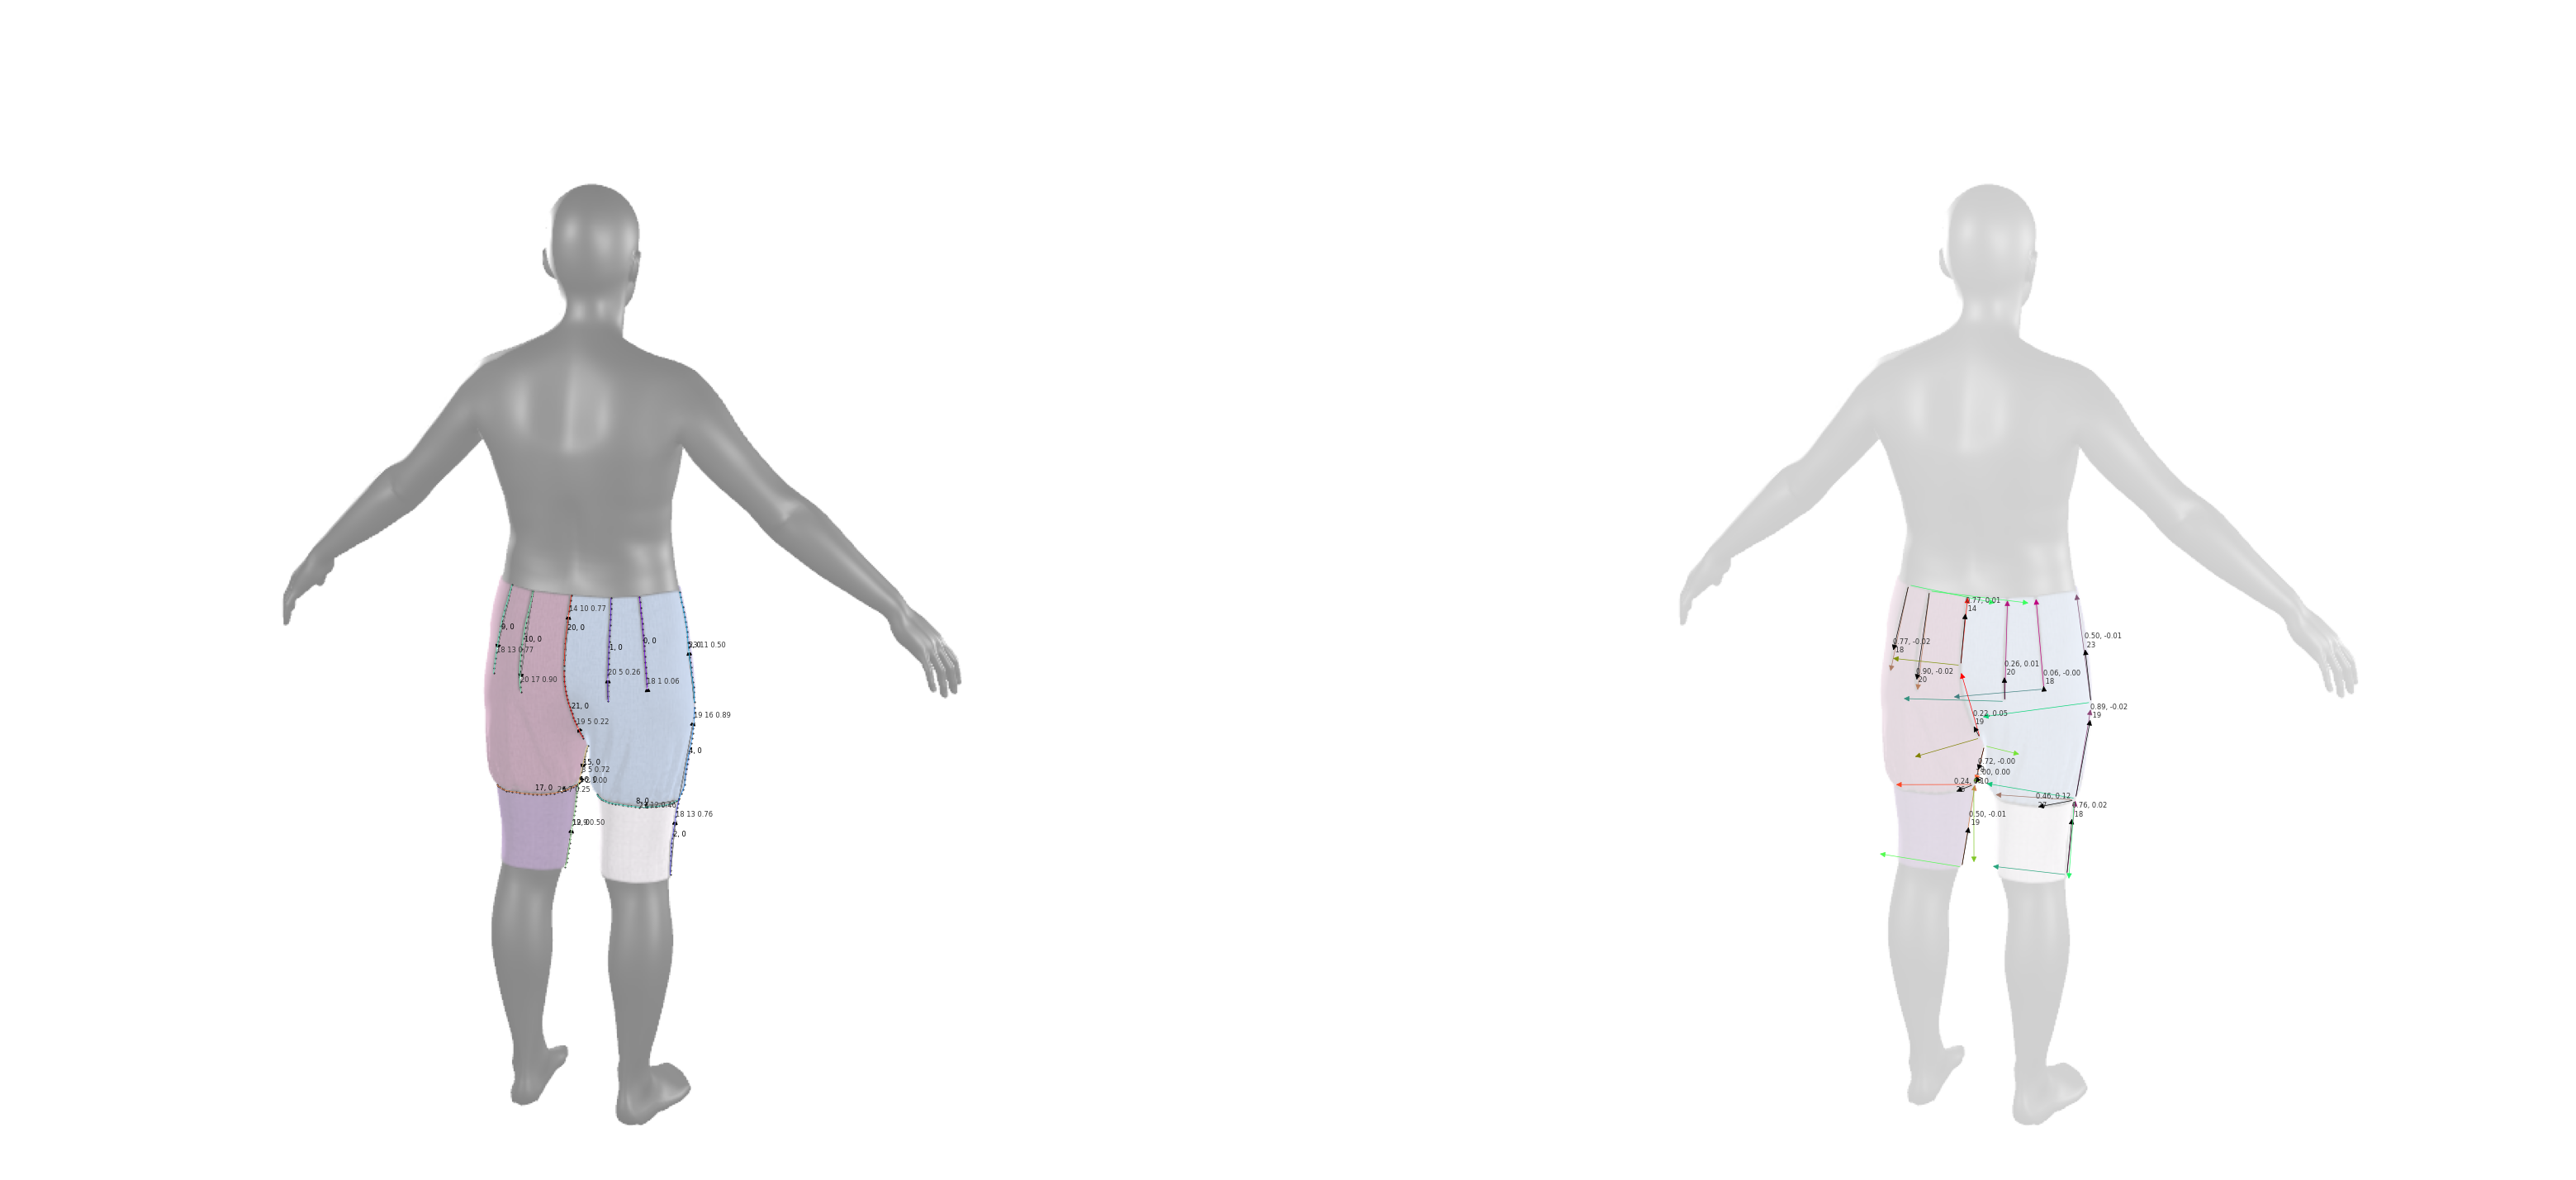

[371.82023936 583.85686767]
[371.82023936 583.85686767]

[374.65963185 505.96922385]
[374.65963185 505.96922385]

[374.87474513 458.62047644]
[374.87474513 458.62047644]

[417.36891498 550.77992285]
[417.36891498 550.77992285]

[356.29873715 549.25160585]
[356.29873715 549.25160585]

[433.73371492 530.0458692 ]
[433.73371492 530.0458692 ]

[445.55514462 444.75198572]
[445.55514462 444.75198572]

[440.26814072 465.80381566]
[440.26814072 465.80381566]



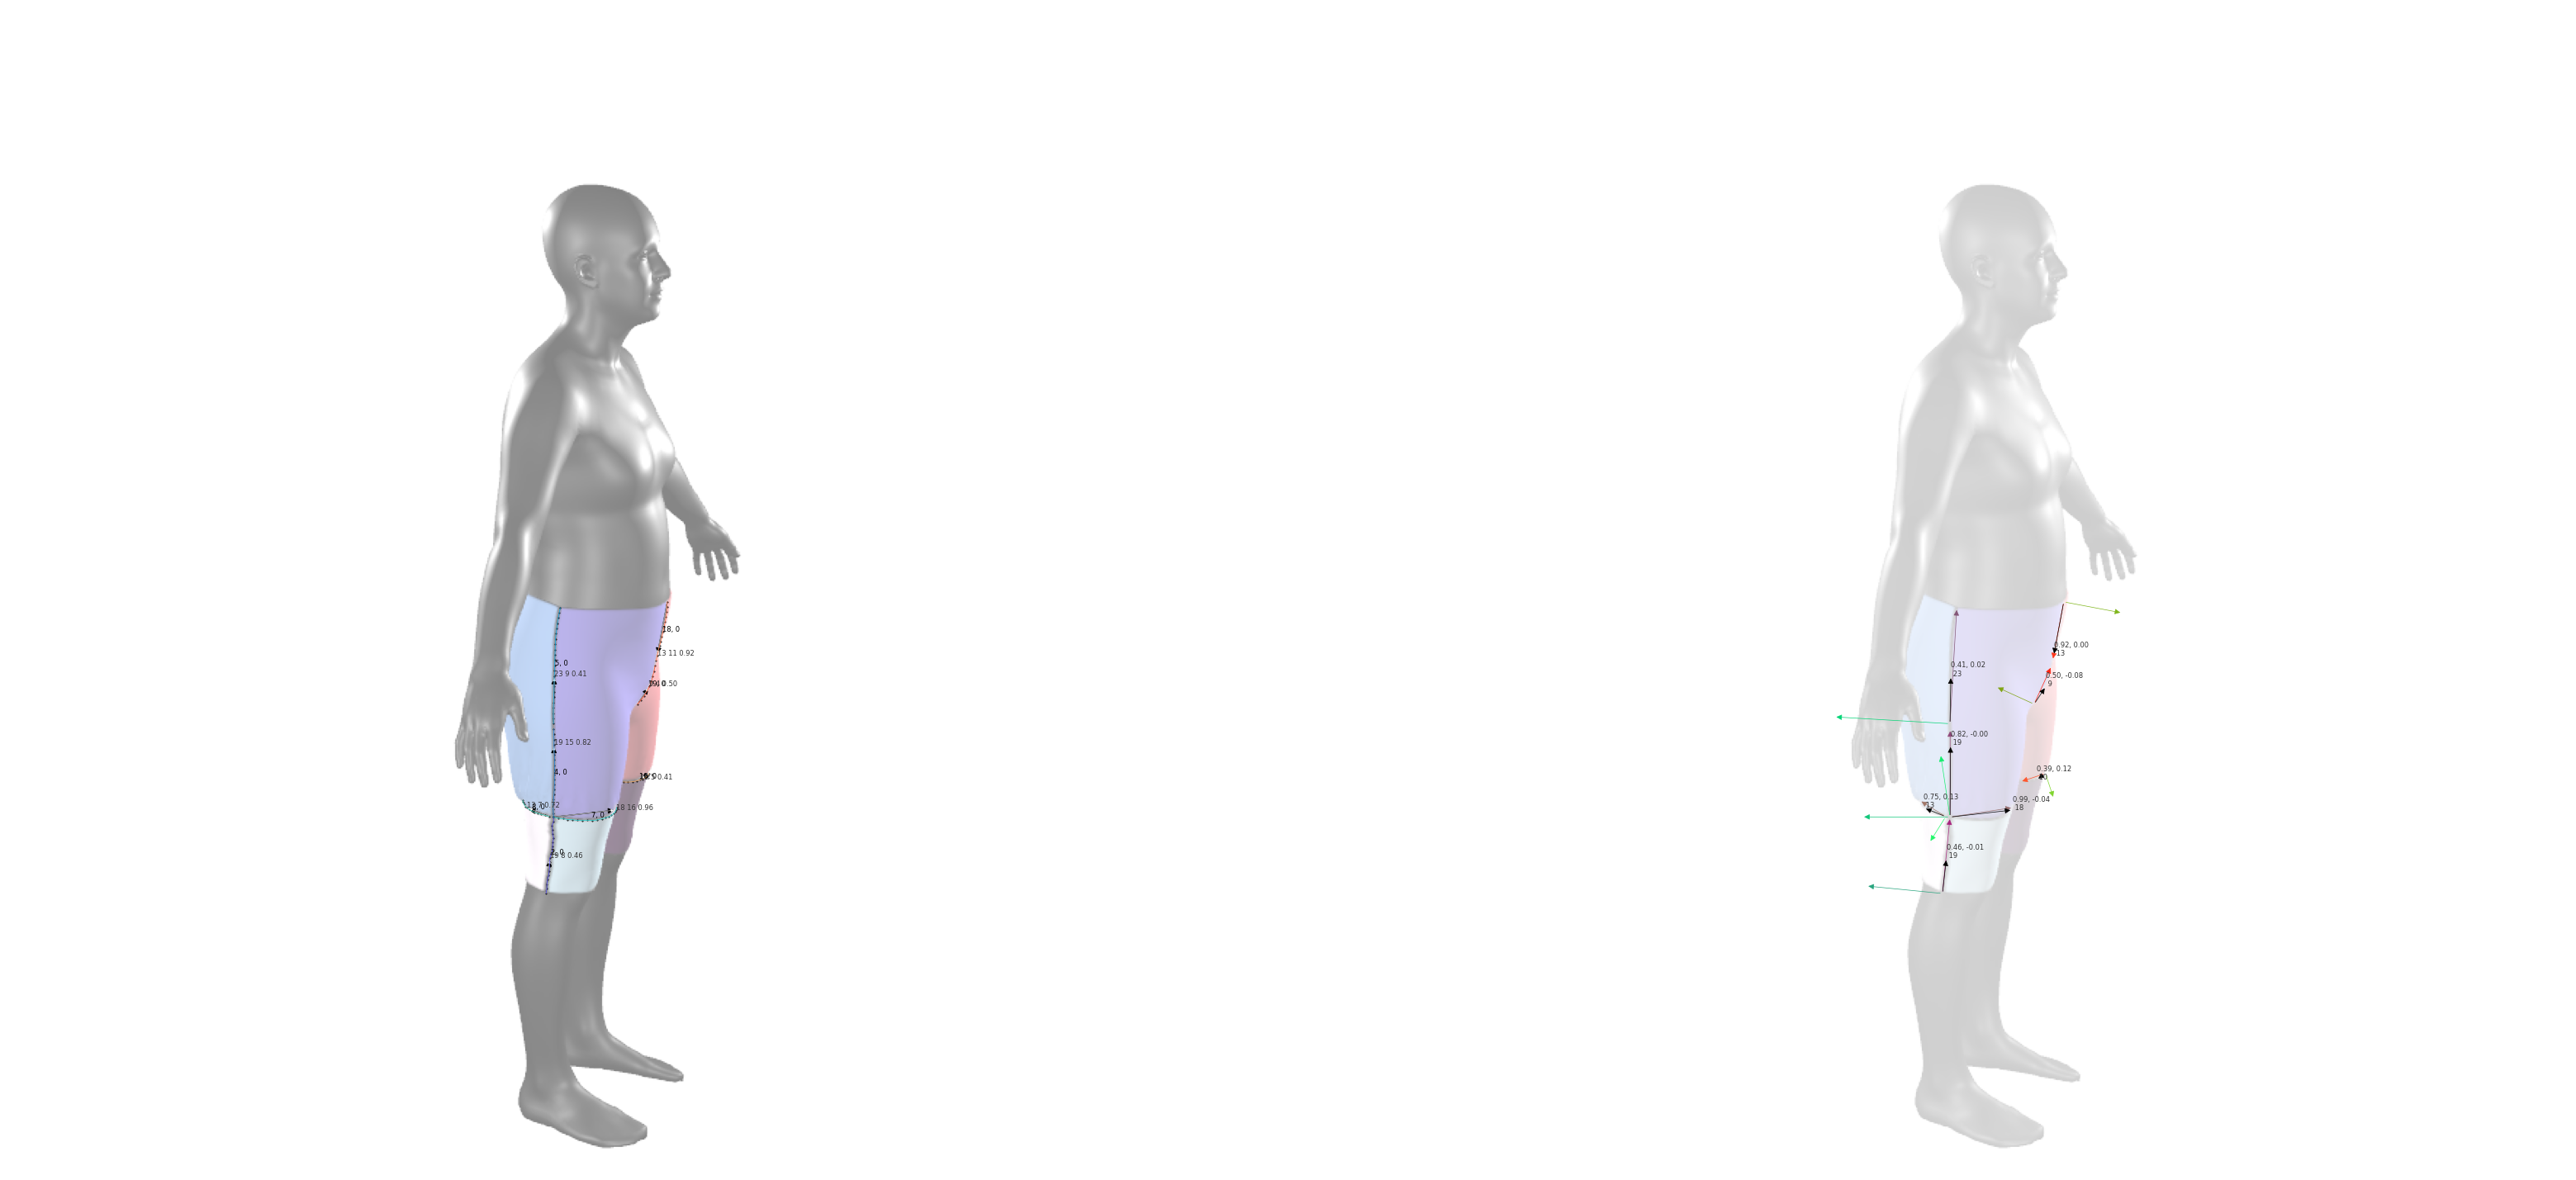

[458.90710517 422.16946491]
[458.90710517 422.16946491]

[441.5374713  525.64591243]
[441.5374713  525.64591243]

[424.49913533 454.6093597 ]
[424.49913533 454.6093597 ]

[438.88216702 431.1305491 ]
[438.88216702 431.1305491 ]

[385.12106915 582.62585269]
[385.12106915 582.62585269]

[375.9388955  512.89515874]
[375.9388955  512.89515874]

[377.13831218 465.91097892]
[377.13831218 465.91097892]

[367.2923239  554.90751006]
[367.2923239  554.90751006]

[420.68768739 549.09078863]
[420.68768739 549.09078863]

[441.19441071 403.37201365]
[441.19441071 403.37201365]

[452.63277886 444.87744371]
[452.63277886 444.87744371]



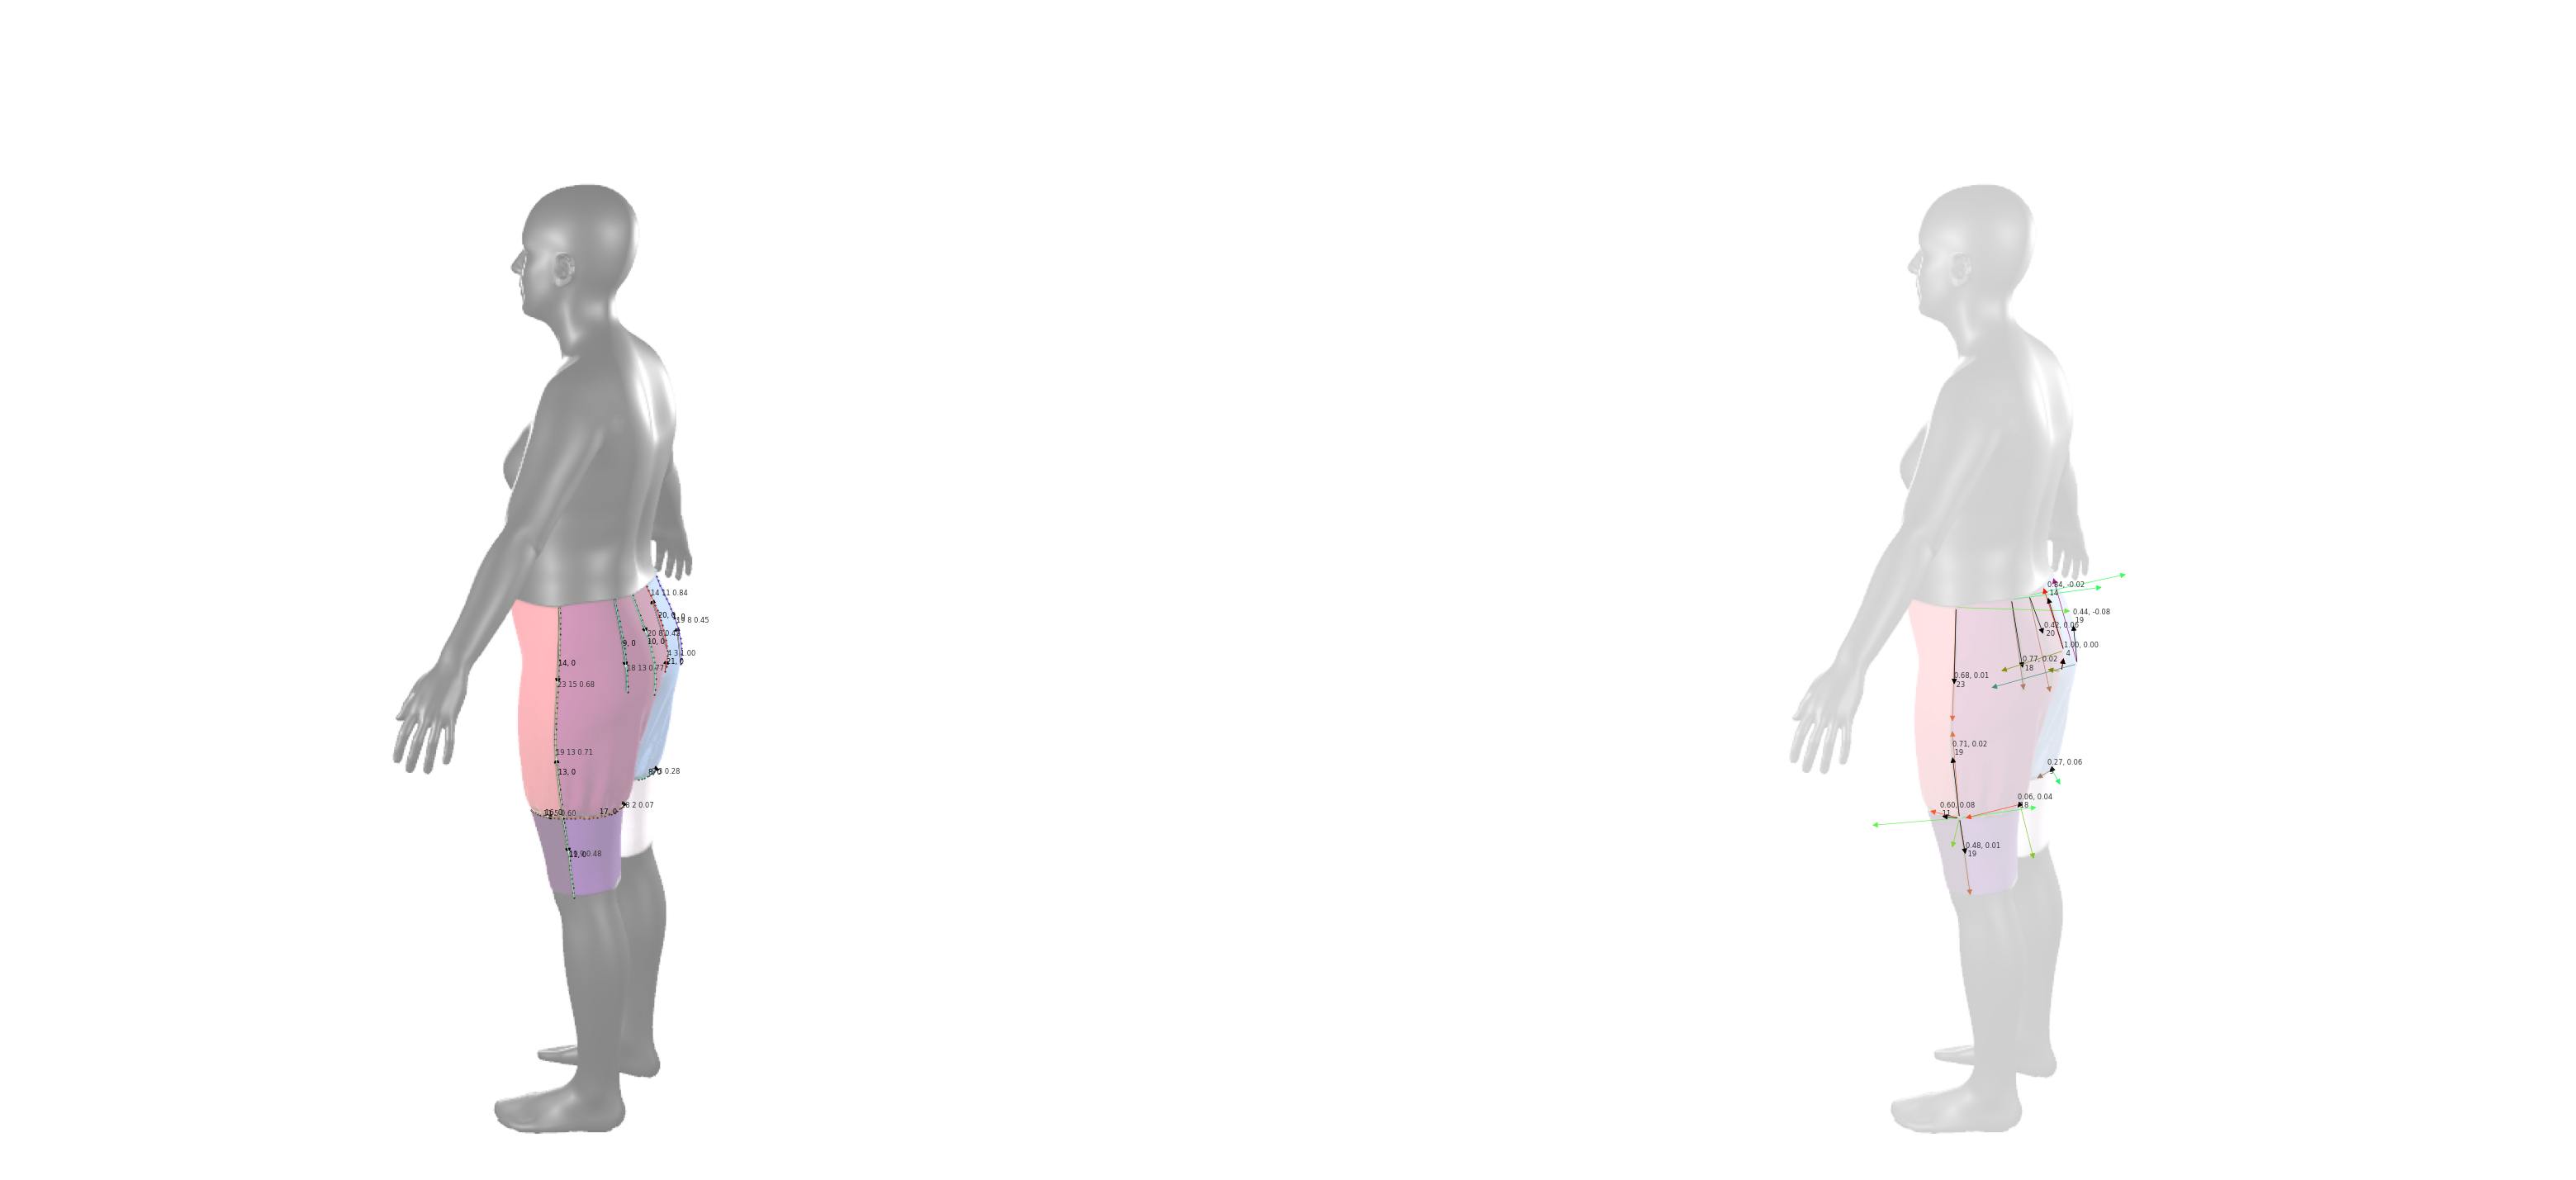

In [246]:

rendered_image_dict = {}
for side in fltrd_vis_seam_line_dict.keys():
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"{garment_id}_render_{side}.png"))

STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

VIS = True
NCOLS = 2
FIGLEN = 20
for side in fltrd_vis_seam_line_dict.keys():
    if VIS :
        plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN))
        ax1 = plt.subplot(1, NCOLS, 1)
        ax1.imshow(rendered_image_dict[side], alpha=0.5)
        ax1.axis("off")
        
        ax2 = plt.subplot(1, NCOLS, 2)
        ax2.imshow(rendered_image_dict[side], alpha=0.2)
        ax2.axis("off")
    
    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        
        segment_edge_len_arr_list = []
        segment_t_arr_list = []
        segment_u_arr_list = []
        segment_v_arr_list = []
        
        for segment_idx, (segment_idx_arr, segment_pos_arr) in enumerate(zip(
            seam_dict["segment_idx_arr_list"],
            seam_dict["segment_pos_arr_list"]
        )):
            
            if len(segment_idx_arr) == 0 :
                continue
            
            i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
            j_vec = np.array([i_vec[1], -i_vec[0]])
            
            i_vec_normalized = i_vec / np.linalg.norm(i_vec)
            j_vec_normalized = j_vec / np.linalg.norm(j_vec)
            
            edge_len_arr = np.concatenate((
                [0],
                np.linalg.norm(segment_pos_arr[1:] - segment_pos_arr[:-1], axis=1)
            ))
            segment_edge_len_arr_list.append(edge_len_arr)
            t_arr = np.cumsum(edge_len_arr) / np.sum(edge_len_arr)
            segment_t_arr_list.append(t_arr)
            
            vect_arr = segment_pos_arr - segment_pos_arr[0]
            u_arr = np.sum(vect_arr * i_vec_normalized, axis=1) / np.linalg.norm(i_vec)
            v_arr = np.sum(vect_arr * j_vec_normalized, axis=1) / np.linalg.norm(j_vec)
            
            segment_t_arr_list.append(t_arr)
            segment_u_arr_list.append(u_arr)
            segment_v_arr_list.append(v_arr)
            
            
            if VIS :    
                # print(
                #     len(segment_idx_arr), len(segment_pos_arr),
                #     len(edge_len_arr), len(t_arr),
                #     len(u_arr), len(v_arr)
                # )
                
                ax1.annotate(
                    f"{seam_idx}, {segment_idx}",
                    xy = (segment_pos_arr.mean(axis=0)),
                    xytext = (segment_pos_arr.mean(axis=0)),
                    fontsize=6
                )
                ax1.plot(
                    segment_pos_arr[:, 0],
                    segment_pos_arr[:, 1],
                    '-',
                    color=colors[seam_idx],
                    linewidth=0.5
                )
                ax1.scatter(
                    segment_pos_arr[:, 0],
                    segment_pos_arr[:, 1],
                    color="black",
                    s=0.2
                )
                
                
                arrow_i = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[0] + i_vec,
                    
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color=np.mean(
                        [colors[seam_idx], np.array([1, 0, 0, 1])],
                        axis=0
                    ),
                    linewidth=0.5
                )
                
                arrow_j = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[0] + j_vec,
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color=np.mean(
                        [colors[seam_idx], np.array([0, 1, 0, 1])],
                        axis=0
                    ),
                    linewidth=0.5
                )
                ax2.add_patch(arrow_i)
                ax2.add_patch(arrow_j)
                
                random_idx = random.randint(0, len(segment_pos_arr) - 1)
                t = t_arr[random_idx]
                u = u_arr[random_idx]
                v = v_arr[random_idx]
                
                
                ax1.annotate(
                    f"{len(segment_pos_arr)} {random_idx} {t:.2f}",
                    xy = (segment_pos_arr[random_idx]),
                    xytext = (segment_pos_arr[random_idx]),
                    fontsize=6, color=(0.2, 0.2, 0.2, 1)
                )
                
                arrow_1 = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[random_idx],
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color='black',
                    linewidth=0.8
                )
                arrow_2 = FancyArrowPatch(
                    segment_pos_arr[0],
                    segment_pos_arr[0] + u * i_vec + v * j_vec,
                    arrowstyle='-|>',
                    mutation_scale=5,
                    color='white',
                    linewidth=0.4
                )
                print(segment_pos_arr[random_idx])
                print(segment_pos_arr[0] + u * i_vec + v * j_vec)
                print()
                
                ax1.add_patch(arrow_1)
                ax1.add_patch(arrow_2)
                
                
                ax2.annotate(
                    f"{u:.2f}, {v:.2f} \n {len(vect_arr)}",
                    xy = (segment_pos_arr[random_idx]),
                    xytext = (segment_pos_arr[random_idx]),
                    fontsize=6, color=(0.2, 0.2, 0.2, 1)
                )
                
                arrow_2 = FancyArrowPatch(
                    segment_pos_arr[0], segment_pos_arr[random_idx],
                    arrowstyle='-|>',
                    mutation_scale=10,
                    color='black',
                    linewidth=0.5
                )
                ax2.add_patch(arrow_2)
                

    if VIS :
        plt.show()

In [167]:
vect_arr

array([[  0.        ,   0.        ],
       [ -0.66424824,   1.20881578],
       [ -3.29134104,   2.25492178],
       [ -6.84935537,   2.78484218],
       [-10.38360573,   3.36782188],
       [-12.62015263,   4.49131229],
       [-13.70764248,   5.84025512],
       [-14.04937912,   7.25845923],
       [-15.13629773,   8.63245912],
       [-17.8625013 ,   9.65632098],
       [-20.95181354,  10.55550087],
       [-23.20588326,  11.71058059],
       [-24.19939052,  13.01156775],
       [-25.3111823 ,  14.31558647],
       [-28.10504669,  15.38402594],
       [-31.59803574,  16.11815529],
       [-35.30848134,  16.42152632],
       [-39.00425386,  16.7933722 ],
       [-42.39888747,  17.63479257],
       [-46.00081314,  18.34541287],
       [-49.50408435,  19.15575061],
       [-53.00624339,  19.94364121],
       [-56.72763168,  20.47349374],
       [-60.46225809,  20.76107381],
       [-64.22971828,  21.16220587],
       [-67.97587021,  21.62753384],
       [-71.7303267 ,  21.79408836],
 

In [182]:
np.sum(vect_arr * i_vec_normalized, axis=1) == u_arr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [184]:
u_arr / np.linalg.norm(i_vec)

array([0.        , 0.0124057 , 0.04820091, 0.09352933, 0.13875609,
       0.17005743, 0.18812904, 0.19734059, 0.21549425, 0.25242064,
       0.29333784, 0.32496537, 0.34171901, 0.35992775, 0.3978387 ,
       0.44309866, 0.48948346, 0.53593237, 0.58037254, 0.62687915,
       0.67253542, 0.71809835, 0.76542143, 0.81204539, 0.85947371,
       0.90686993, 0.95330604, 1.        ])

In [185]:
v_arr / np.linalg.norm(j_vec)

array([0.        , 0.01240043, 0.01584028, 0.00966972, 0.00423147,
       0.01000381, 0.02261154, 0.03871458, 0.05163031, 0.05444643,
       0.05445   , 0.06054581, 0.07290189, 0.08487473, 0.08799477,
       0.08454876, 0.0750703 , 0.0664801 , 0.06469363, 0.06057351,
       0.05802152, 0.05519938, 0.04844753, 0.03869035, 0.03020305,
       0.02257534, 0.0112699 , 0.        ])

In [183]:
np.sum(vect_arr * j_vec_normalized, axis=1) == v_arr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [175]:
vect_arr / i_vec_normalized

array([[-0.        ,  0.        ],
       [ 0.6917952 ,  4.32677239],
       [ 3.42783583,  8.07114987],
       [ 7.13340413,  9.96791943],
       [10.81422296, 12.05460669],
       [13.14352141, 16.07596987],
       [14.27611042, 20.90430577],
       [14.63201918, 25.98055187],
       [15.76401326, 30.8985757 ],
       [18.60327488, 34.56333364],
       [21.8207036 , 37.78181144],
       [24.16825157, 41.91624379],
       [25.20296045, 46.57292963],
       [26.36085921, 51.24046648],
       [29.2705876 , 55.06478322],
       [32.90843396, 57.69248767],
       [36.772755  , 58.77835818],
       [40.62179444, 60.109324  ],
       [44.15720648, 63.12106035],
       [47.90850717, 65.66461774],
       [51.5570621 , 68.56509854],
       [55.20445874, 71.38523323],
       [59.08017627, 73.28175983],
       [62.96968091, 74.31110901],
       [66.89338097, 75.74690026],
       [70.7948891 , 77.41247104],
       [74.70504619, 78.00862761],
       [78.63466638, 78.63466638]])

In [171]:
i_vec

array([-75.50347127,  21.96899137])

In [173]:
j_vec / j_vec_normalized

array([78.63466638, 78.63466638])

In [174]:
i_vec / i_vec_normalized

array([78.63466638, 78.63466638])

In [17]:
count = 0
for side in fltrd_vis_seam_line_dict.keys():
    for stch_idx in fltrd_vis_seam_line_dict[side].keys():
        for segment_idx, segment_idx_list in enumerate(fltrd_vis_seam_line_dict[side][stch_idx]["segment_idx_list"]):
            if len(segment_idx_list) > 0 :
                count += 1
print(count)

count2 = 0
for panel_name, panel in panel_svg_path_dict.items():
    count2 += len(list(panel[0]))
print(count2)

98
84


84


## Read From saved data

In [12]:
PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(PROJECT_ROOT_PATH, "neutral_body/mean_all.obj")
BODY_TYPE = "default_body"

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "garments_*", BODY_TYPE, "*"))
)))


def filterer(garment_path):
    garment_id = os.path.basename(garment_path)
    data = True
    for side in ["front", "back", "right", "left"] :
        if not os.path.exists(os.path.join(garment_path, f"{garment_id}_render_{side}.png")) :
            data = False
            break
    if not os.path.exists(os.path.join(garment_path, "fltrd_vis_seam_line_dict.pkl")) :
        data = False
    return data

garment_path_list = list(filter(filterer, garment_path_list))



print(len(garment_path_list))


495


13 rand_07EKIQJMNA


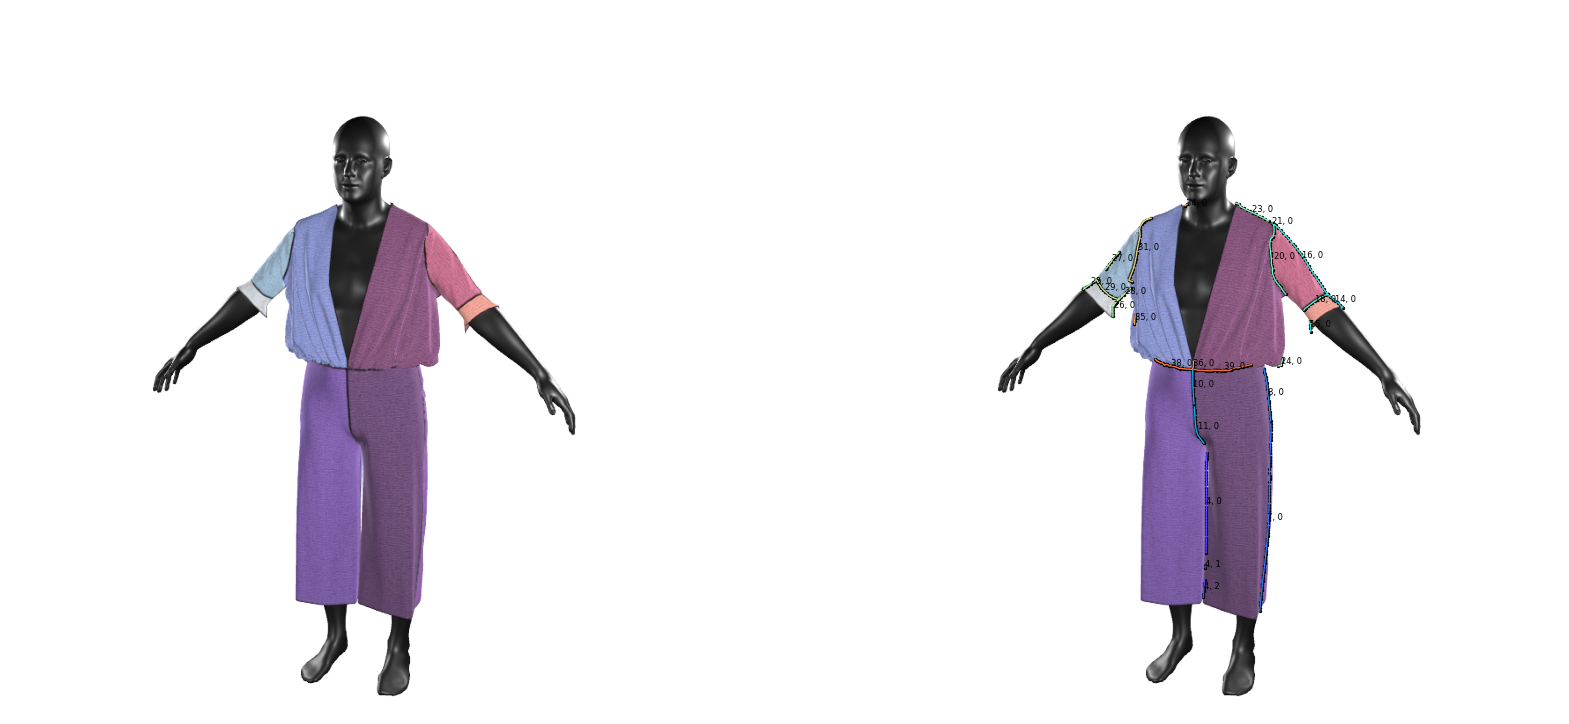

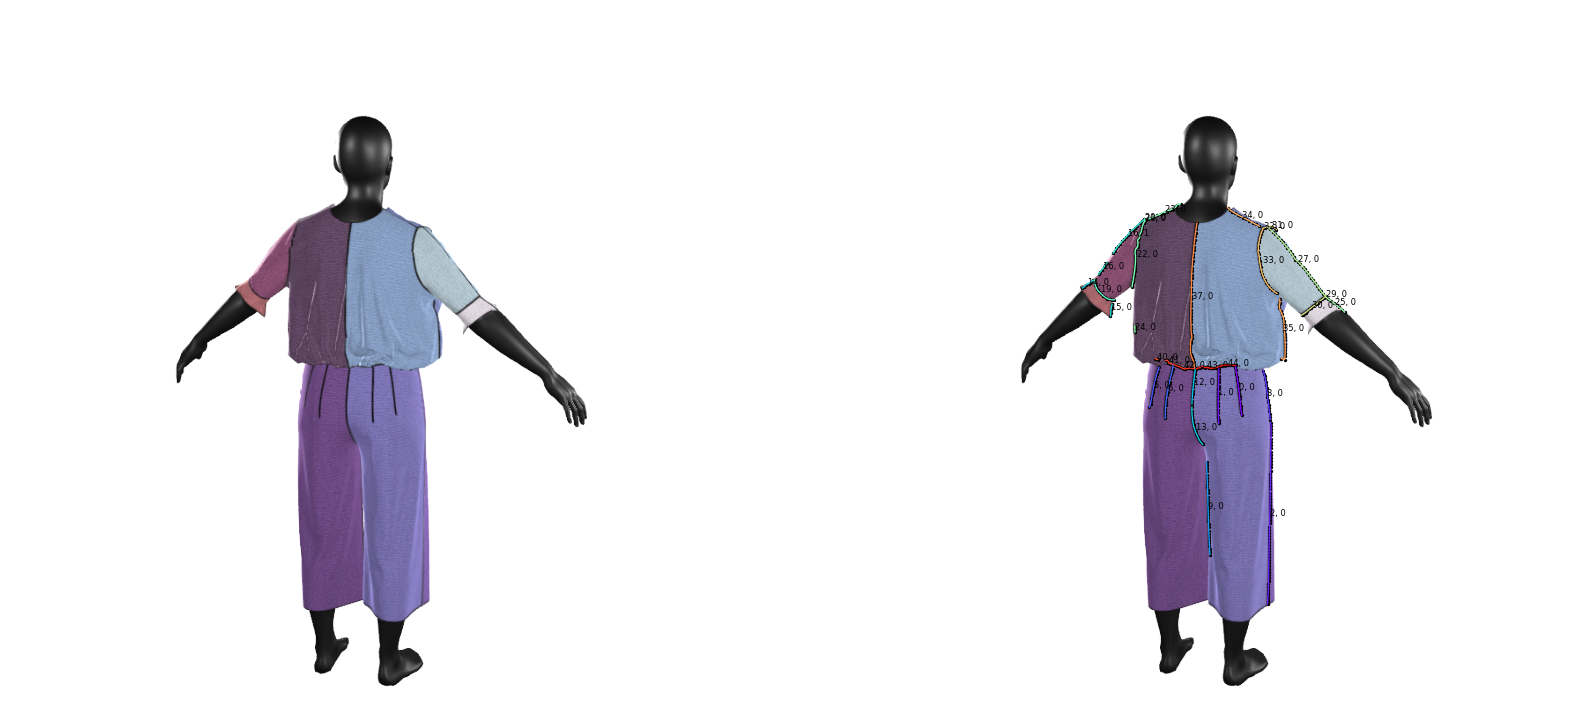

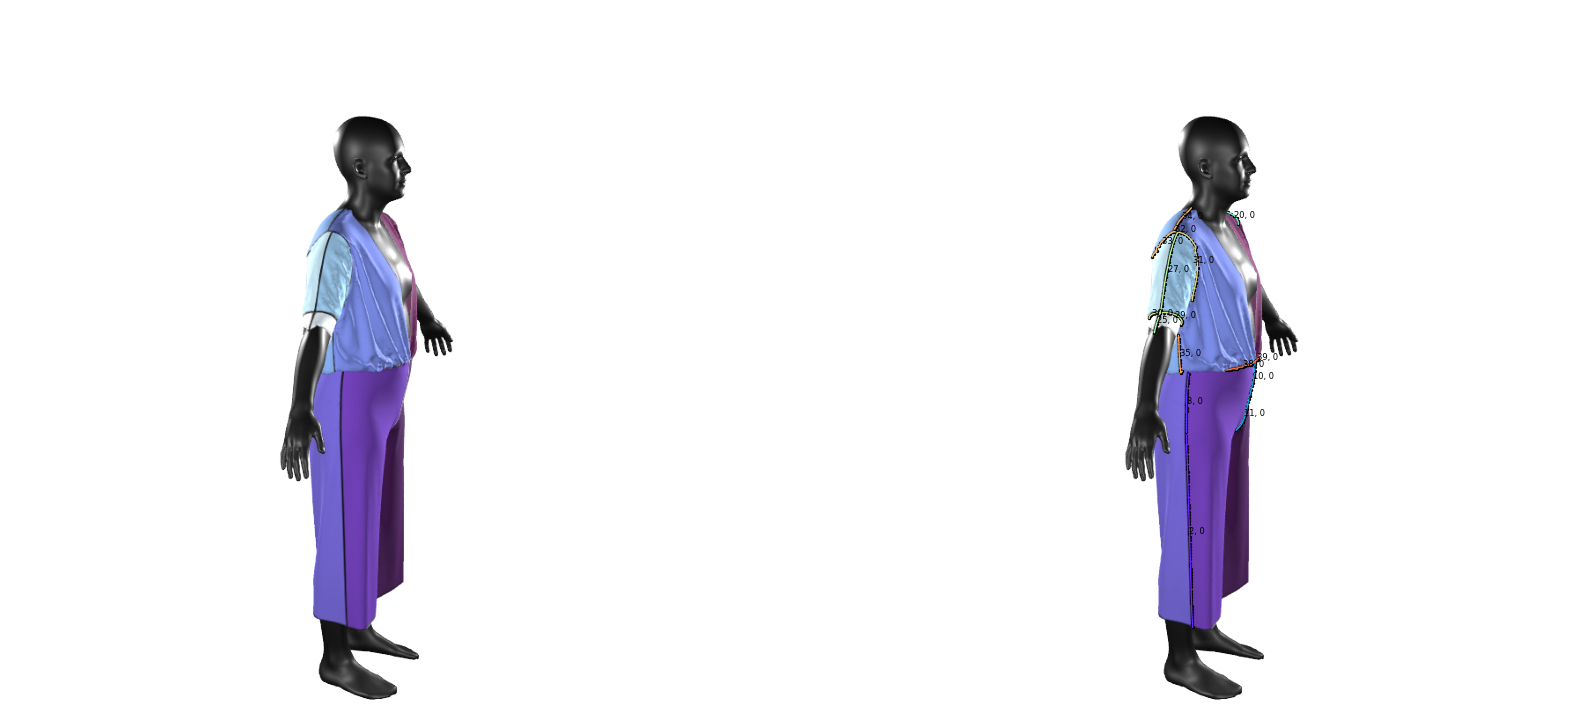

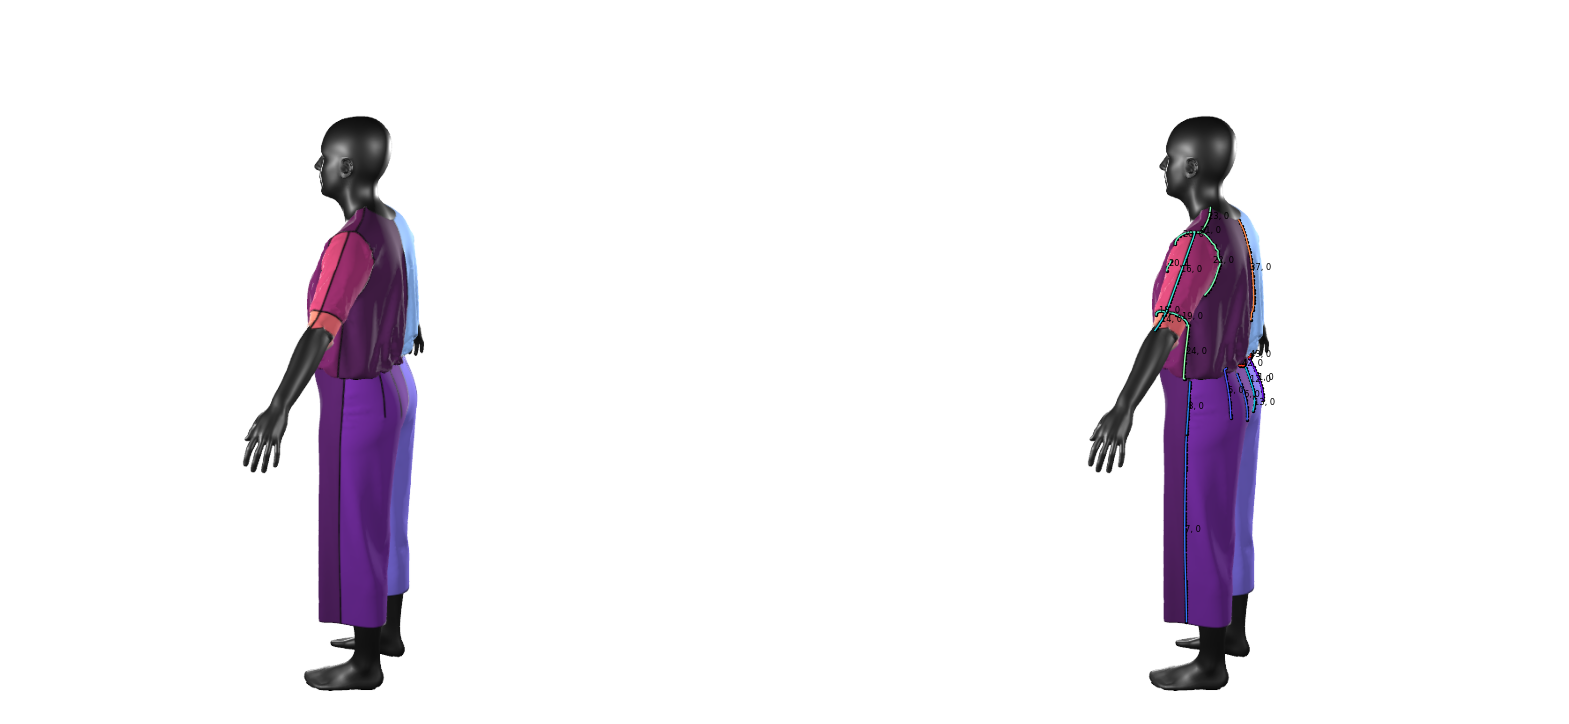

In [25]:
import random

IDX = random.randint(0, len(garment_path_list) - 1)
garment_path = garment_path_list[IDX]

# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_3/default_body/rand_005ZYVMOCL"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_30/default_body/rand_0007Y6GF28"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_33/default_body/rand_007X3JPYRP"
# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_18/default_body/rand_00Y0CP5OIX"

garment_id = os.path.basename(garment_path)
print(IDX, garment_id)

rendered_image_dict = {}
for side in ["front", "back", "right", "left"]:
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"{garment_id}_render_{side}.png"))
with open(os.path.join(garment_path, "fltrd_vis_seam_line_dict.pkl"), "rb") as f:
    fltrd_vis_seam_line_dict_loaded = pickle.load(f)    

rendered_image_dict = {}
for side in fltrd_vis_seam_line_dict_loaded.keys():
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"{garment_id}_render_{side}.png"))

STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict_loaded.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side in fltrd_vis_seam_line_dict_loaded.keys():
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1); plt.imshow(rendered_image_dict[side]); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(rendered_image_dict[side]); plt.axis("off")
    for seam_idx, seam_dict in fltrd_vis_seam_line_dict_loaded[side].items():
        for segment_idx, segment_pos_list in enumerate(seam_dict["segment_pos_list"]):
            x = [pos[0] for pos in segment_pos_list]
            y = [pos[1] for pos in segment_pos_list]
            mx = np.mean(x); my = np.mean(y)
            plt.annotate(f"{seam_idx}, {segment_idx}", xy = (mx, my), xytext = (mx, my), fontsize=6)
            plt.plot(x, y, '-', color=colors[seam_idx], linewidth=1)
            plt.scatter(x, y, color="black", s=2)

    plt.show()
